Name: Osama Sidahmed

Date:20 Oct 2021

### Dataset

This notebook includes my work on the data preparation and data clustering of the Brazilian E-Commerce Public Dataset by Olist version 6 dataset.

The dataset was downloaded from the new [here](https://www.kaggle.com/olistbr/brazilian-ecommerce).

As per the website, this is the **description** of the dataset:

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.
This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

Context: 

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com
After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

Attention:
1.	An order might have multiple items.
2.	Each item might be fulfilled by a distinct seller.
3.	All text identifying stores and partners where replaced by the names of Game of Thrones great houses.

Example of a product listing on a marketplace:

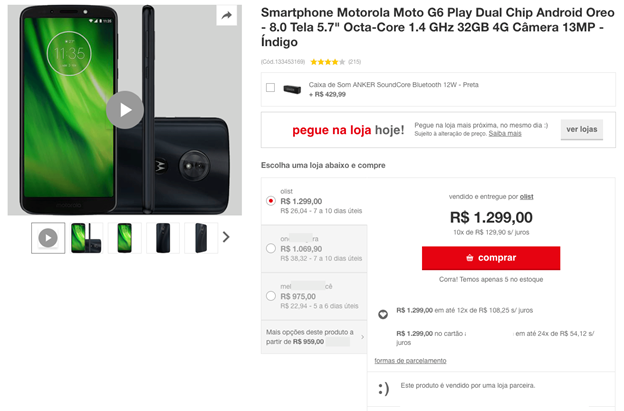

Data Schema

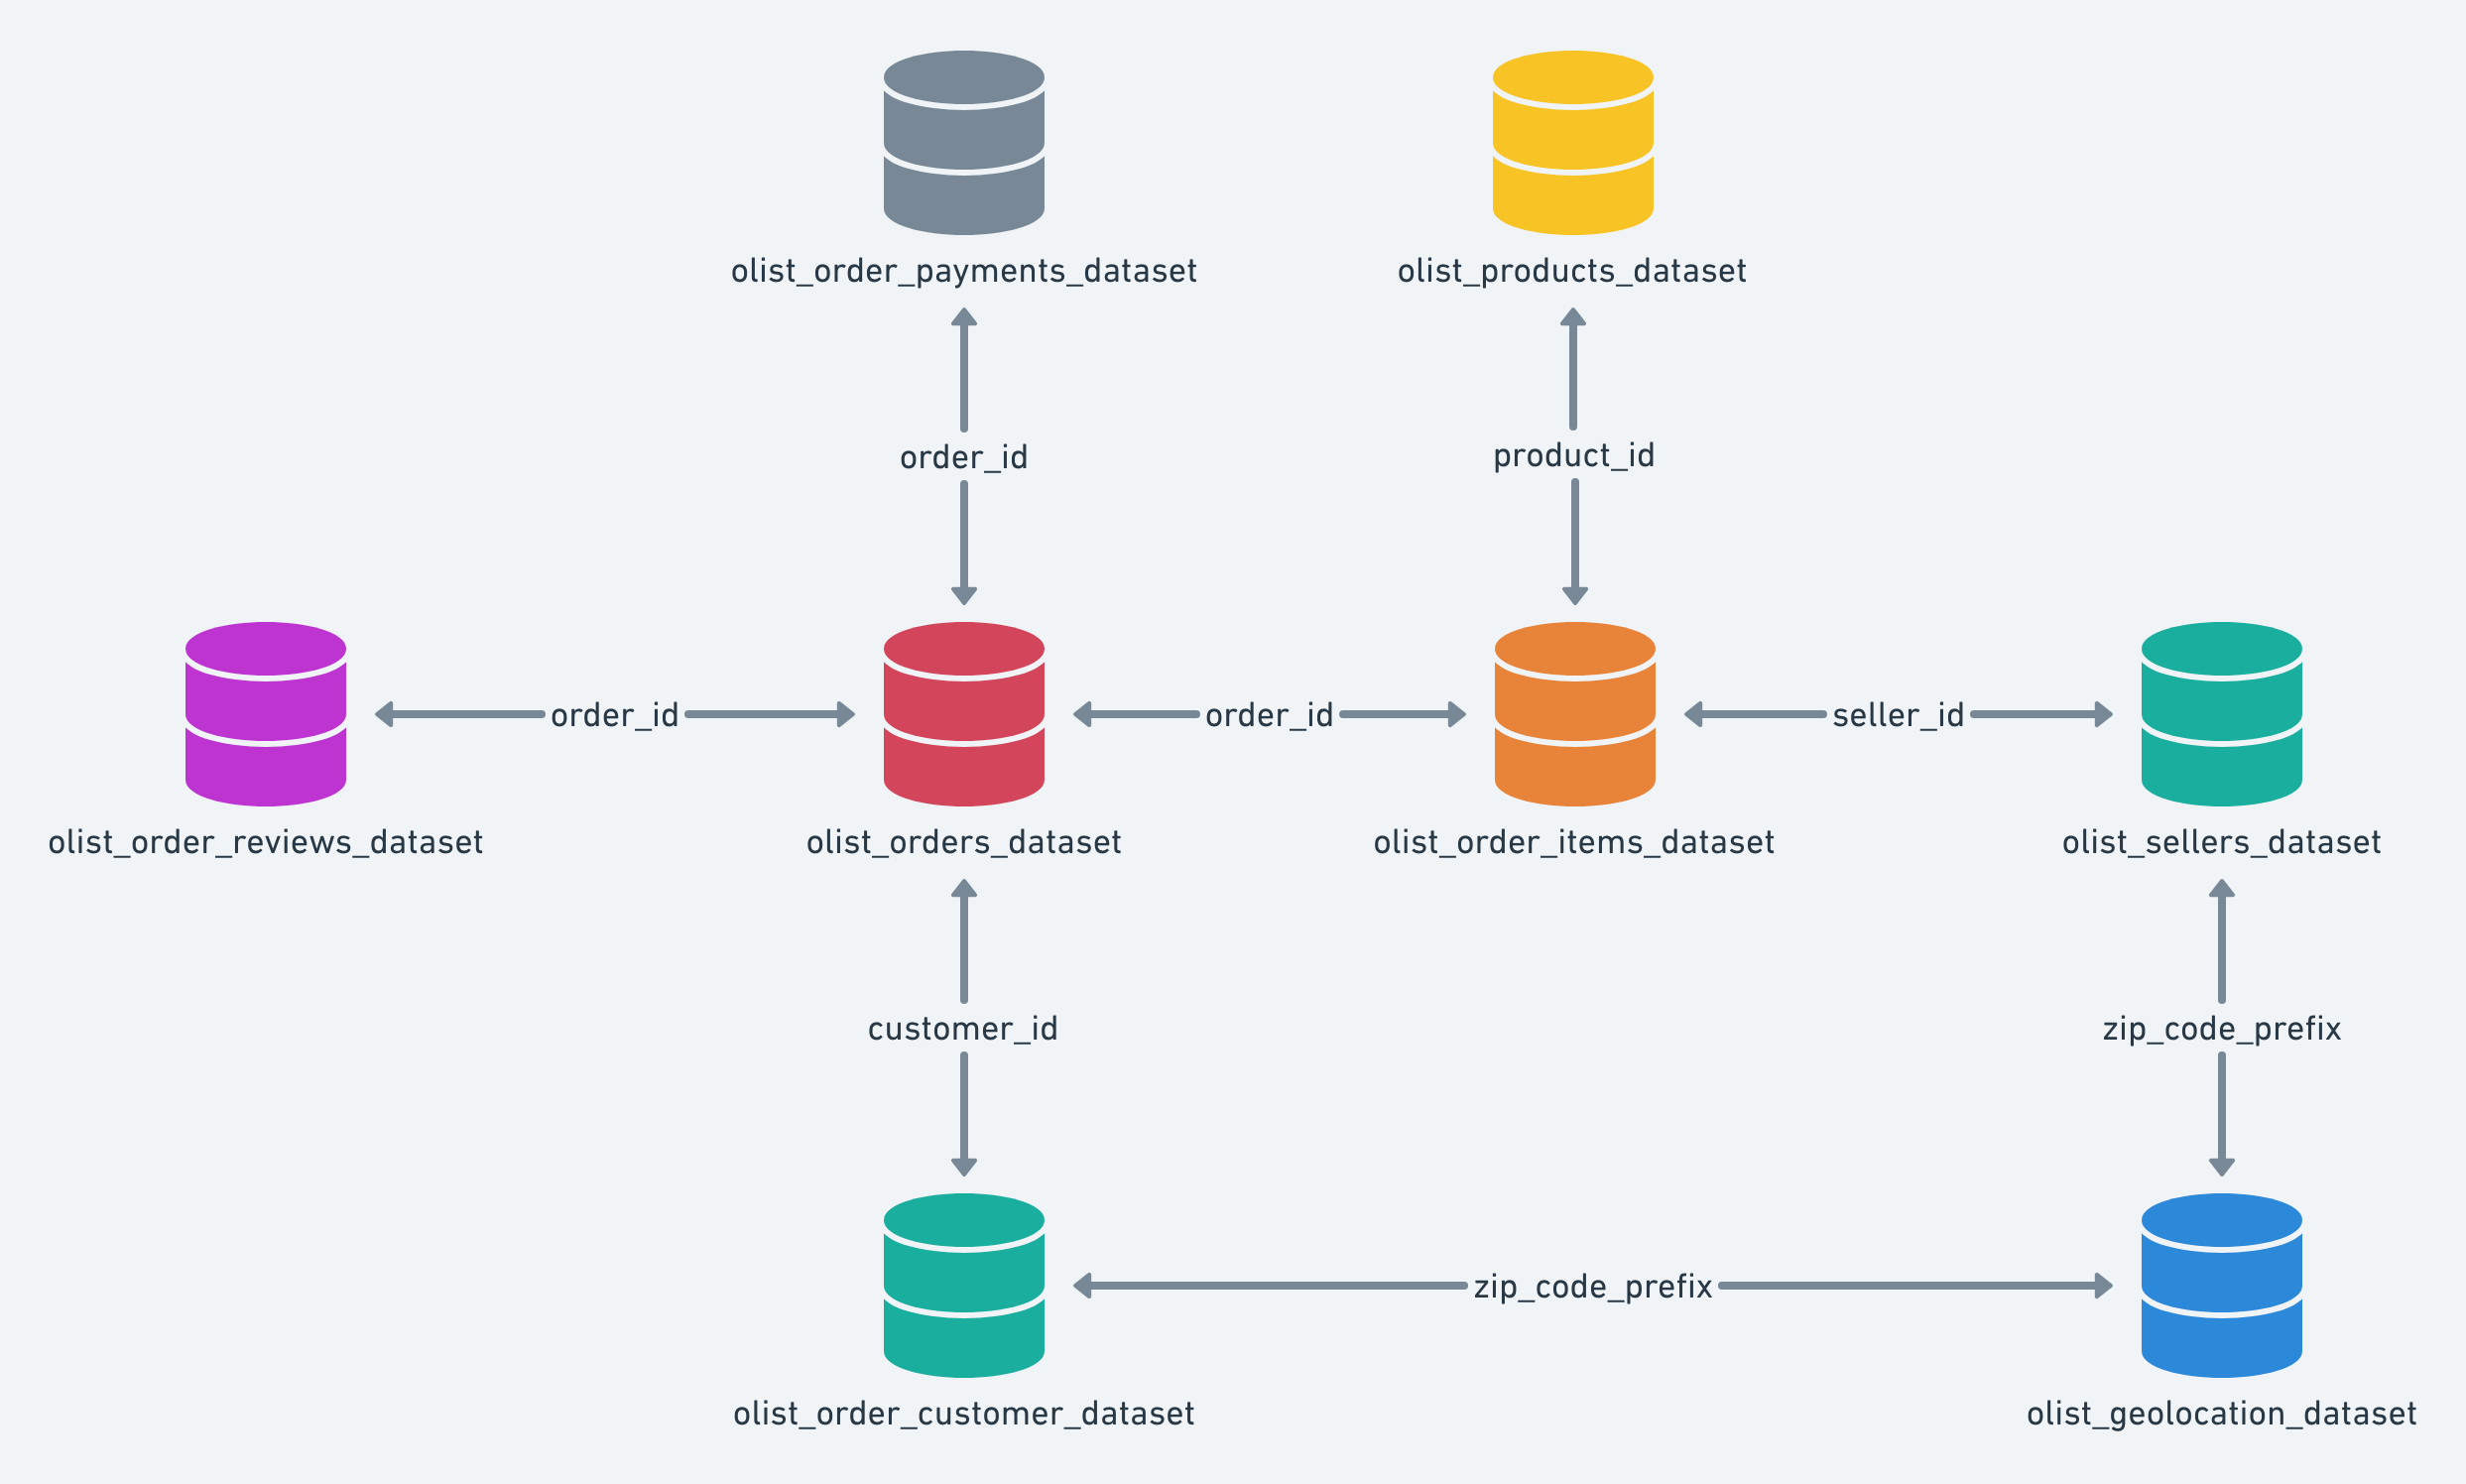

### Objective (Problem Understanding)
The main objective of this project is to apply various clustering algorithms to find customers with natural similarities.

### Data Understanding

Although the data on this project dictated the problem definition, it is important to mention that the data on its current state is not designed for such analysis before some munging. First off, the data is scattered on different tables requiring merging all tables together before we redefining it at the customer level instead of the order level that it is at initially.  

#### Initial Exploratory Data Analysis

In [1686]:
# Load some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1687]:
# Set preference to show all dataframes columns
pd.set_option('display.max_column', None)
pd.set_option('max_colwidth', None)

The dataset is composed of 9 csv files. The first step is to load all of the into dataframes.

In [1688]:
df_customers = pd.read_csv("data/olist_customers_dataset.csv", index_col=0)
df_geolocation = pd.read_csv("data/olist_geolocation_dataset.csv", index_col=0)
df_order_items = pd.read_csv("data/olist_order_items_dataset.csv", index_col=0)
df_order_payments = pd.read_csv("data/olist_order_payments_dataset.csv", index_col=0)
df_order_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv", index_col=0)
df_orders = pd.read_csv("data/olist_orders_dataset.csv", index_col=0)
df_products = pd.read_csv("data/olist_products_dataset.csv", index_col=0)
df_sellers = pd.read_csv("data/olist_sellers_dataset.csv", index_col=0)
df_product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv", index_col=0)

In [1689]:
# store the 9 dfs in a dictionary to ease manipulation
df_dict = {'df_customers': df_customers, 'df_geolocation': df_geolocation,'df_order_items': df_order_items,  \
           'df_order_payments': df_order_payments,  'df_order_reviews': df_order_reviews,  'df_orders': df_orders, \
           'df_products': df_products, 'df_sellers': df_sellers,'df_product_category_name_translation': df_product_category_name_translation}


# print a sample of each
for key, value in df_dict.items():
    print(key)
    display(value.sample(3))
    print('--------------------------------------------------------------------------------------------------------------------------')

df_customers


,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
customer_id,,,,
214da6d258e415ee782fd14c108be3a2,486a411f40fe3cbdf049451bd713d2be,35380,urucania,MG
961f898c34ac62fa12fd8249612de4e6,170f73c3d7e5b15778aa114625ef0e8e,1242,sao paulo,SP
11ab6d2231a0af5746b44a810b62b0a1,a6cc6e3138236cf4795743335351594c,73700,padre bernardo,GO


--------------------------------------------------------------------------------------------------------------------------
df_geolocation


,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
geolocation_zip_code_prefix,,,,
65390,-3.965071,-45.662828,santa luzia,MA
20941,-22.899514,-43.218126,rio de janeiro,RJ
98740,-28.517963,-53.989466,augusto pestana,RS


--------------------------------------------------------------------------------------------------------------------------
df_order_items


,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
order_id,,,,,,
b1746c7d13f52567b4cd6710249240c9,1,d017a2151d543a9885604dc62a3d9dcc,6560211a19b47992c3666cc44a7e94c0,2017-07-20 14:15:11,49.0,7.78
8c077233d04d9bca0a5bef45afddf354,1,94475071013412139f862c0bd7e3bb37,955fee9216a65b617aa5c0531780ce60,2018-08-07 04:10:24,42.0,15.39
7d00af7c23ec65f8e98e9d7a348130f4,1,2043cae78c8b731c405c7329a05154b2,4830e40640734fc1c52cd21127c341d4,2018-05-18 18:16:29,69.0,19.45


--------------------------------------------------------------------------------------------------------------------------
df_order_payments


,payment_sequential,payment_type,payment_installments,payment_value
order_id,,,,
71425ecd58b4f20236e557902a9743f7,2,voucher,1,28.67
4a086aa623133c7141b0c9c6759c79ad,1,credit_card,2,74.38
ff69de2237431040b7e8d1fcd79c0a7a,1,credit_card,10,117.76


--------------------------------------------------------------------------------------------------------------------------
df_order_reviews


,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
e0eb04c8ab161f96dd15632bcd5d873f,82a71647905d5965a2d4c6e237ad3e61,3,NaN,NaN,2017-08-03 00:00:00,2017-08-03 23:51:03
95e2291759afb8251aa7ce538cce9458,cf229e9a3df6543d25bd826262a12a8a,4,NaN,NaN,2017-08-15 00:00:00,2017-08-16 08:27:36
b5840ffc61a111d760b759fc343f861d,87064d517041a71950b9f0cf6d34b211,5,NaN,NaN,2017-05-14 00:00:00,2017-05-14 21:31:15


--------------------------------------------------------------------------------------------------------------------------
df_orders


,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_id,,,,,,,
4007c8123697940f0574798a18c6ad29,aafe511008ceeac11be1fdab57f9bd8e,delivered,2018-05-26 18:50:39,2018-05-26 19:10:19,2018-05-29 12:47:00,2018-06-05 20:33:01,2018-07-04 00:00:00
ef29bdd3a72229e6ea76fb22871eb176,ff83d65f64369c7efaa074eb0a13c433,delivered,2018-01-15 22:45:22,2018-01-15 22:55:25,2018-01-18 15:49:11,2018-01-24 19:49:15,2018-02-09 00:00:00
87d003714879bdc9c2adfe35a47268a4,99bfe4238b5b10a3e83b388a471e3568,delivered,2017-12-06 22:33:42,2017-12-08 02:54:32,2017-12-11 20:53:37,2018-01-02 20:29:10,2018-01-09 00:00:00


--------------------------------------------------------------------------------------------------------------------------
df_products


,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
product_id,,,,,,,,
77922dd87928c2cf9225946dac2a27a7,moveis_decoracao,60.0,600.0,1.0,650.0,25.0,25.0,25.0
f78d57eae3aa976bdfd5f0db33141a79,cama_mesa_banho,58.0,204.0,1.0,2100.0,35.0,20.0,30.0
d87fc3441d23a38e9921cd2fa603b931,casa_construcao,55.0,652.0,1.0,3950.0,30.0,35.0,30.0


--------------------------------------------------------------------------------------------------------------------------
df_sellers


,seller_zip_code_prefix,seller_city,seller_state
seller_id,,,
7dc8c42cc750eeafea6c85712ffee9bf,5424,sao paulo,SP
609e1a9a6c2539919b8205cf7c4e6ff0,88359,brusque,SC
b2f4d63c7203f539a78252565ca32257,28950,armacao dos buzios,RJ


--------------------------------------------------------------------------------------------------------------------------
df_product_category_name_translation


,product_category_name_english
product_category_name,
fashion_bolsas_e_acessorios,fashion_bags_accessories
moveis_colchao_e_estofado,furniture_mattress_and_upholstery
market_place,market_place


--------------------------------------------------------------------------------------------------------------------------


**Data Dictionary**

`customer_id`: 
key to the orders dataset. Each order has a unique customer_id.

`customer_unique_id`: 
unique identifier of a customer.

`customer_zip_code_prefix`: 
first five digits of customer zip code

`customer_city`: 
customer city name

`customer_state`: 
customer state

-------
`geolocation_zip_code_prefix`: 
first 5 digits of zip code

`geolocation_lat`: 
latitude

`geolocation_lng`: 
longitude

`geolocation_city`: 
city name

`geolocation_state`: 
state

-----
`order_id`: 
order unique identifier

`order_item_id`: 
sequential number identifying number of items included in the same order.

`product_id`: 
product unique identifier

`seller_id`: 
seller unique identifier

`shipping_limit_date`: 
Shows the seller shipping limit date for handling the order over to the logistic partner.

`price`: 
item price

`freight_value`: 
item freight value item (if an order has more than one item the freight value is splitted between items)

------------
`order_id`: 
unique identifier of an order.

`payment_sequential`: 
a customer may pay an order with more than one payment method. If he does so, a sequence will be created to accommodate all payments.

`payment_type`: 
method of payment chosen by the customer.

`payment_installment`s: 
number of installments chosen by the customer.

`payment_value`: 
transaction value.

----------
`review_id`: 
unique review identifier

`review_score`: 
Note ranging from 1 to 5 given by the customer on a satisfaction survey.

`review_comment_title`: 
Comment title from the review left by the customer, in Portuguese.

`review_comment_message`: 
Comment message from the review left by the customer, in Portuguese.

`review_creation_date`: 
Shows the date in which the satisfaction survey was sent to the customer.

`review_answer_timestamp`: 
Shows satisfaction survey answer timestamp.

------------
`order_id`: 
unique identifier of the order.

`order_status`: 
Reference to the order status (delivered, shipped, etc).

`order_purchase_timestamp`: 
Shows the purchase timestamp.

`order_approved_at`: 
Shows the payment approval timestamp.

`order_delivered_carrier_date`: 
Shows the order posting timestamp. When it was handled to the logistic partner.

`order_delivered_customer_date`: 
Shows the actual order delivery date to the customer.

`order_estimated_delivery_date`: 
Shows the estimated delivery date that was informed to customer at the purchase moment.

---------------
`product_id`: 
unique product identifier

`product_category_name`: 
root category of product, in Portuguese.

`product_name_lenght`: 
number of characters extracted from the product name.

`product_description_lenght`: 
number of characters extracted from the product description.

`product_photos_qty`: 
number of product published photos

`product_weight_g`: 
product weight measured in grams.

`product_length_cm`: 
product length measured in centimeters.

`product_height_cm`: 
product height measured in centimeters.

`product_width_cm`: 
product width measured in centimeters.

-----------
`seller_id`: 
seller unique identifier

`seller_zip_code_prefix`: 
first 5 digits of seller zip code

`seller_city`: 
seller city name

`seller_state`: 
seller state

----------
`product_category_name`: 
category name in Portuguese

`product_category_name_english`: 
category name in English

For each order, we have data to show:
- who bought the item and where they live (zip code, city, state, LAT and LONG)
- order details, the item, the seller, the time the order was shipped, its price and cost of shipping
- payment details, the type of payment (credit card, voucher, etc..) and the number of installments and the total payment value
- order review, with score and comments in Spanish
- order delivery details, when it was approved, estimated and actual delivery dates
- order item details, size, weight and the listing number of photos
- seller location details
- English translation of product category names

Now, after looking at the data at a glance, we need to ask if our data is complete, accurate and relevant to our problem. Since we are going to do unsupervised learning here, mimicking a scenario where we are using all the data we have, we can safely assume that our data is compete (to be confirmed), accurate and relevant.

We can see that the data is huge and is scattered in several tables with links represented by IDs and keys. We can take different approaches to get down to the final data to use in our analysis, since this is an unsupervised learning exercise, we will leave the step of reducing our features size to the end after we combine all dataframes in one. 

#### The Plan

To follow a structured approach, we need to do the following to achieve our objective stated above:
- Data preparation and processing:
    - join all dataframes into one dataframe
    - clean the dataframe for duplicated and missing data and impute data if applicable
    - transform the data into a customer level data meaning that it the instance level will be customers instead of order. This step may require data grouping and summarizing and perhaps creating new features
    - omit all irrelevant features
- Modelling & Evaluation    
    - Use various unsupervised learning techniques to cluster customers

*This is an initial plan, some changes and iterations may come along the way.*

#### Data Preparation

In [1690]:
# magic function to see all active variables in the kernel
%whos

Variable                                   Type                          Data/Info
----------------------------------------------------------------------------------
OneHotEncoder                              type                          <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
count_list                                 list                          n=2
date_list                                  list                          n=8
df_customers                               DataFrame                                              <...>n[99441 rows x 4 columns]
df_dict                                    dict                          n=9
df_geolocation                             DataFrame                                              <...>1000163 rows x 4 columns]
df_geolocation_avg                         DataFrame                                              <...>n[19015 rows x 2 columns]
df_list                                    list                          n=4
df_ocj_m  

##### Join all dataframes into one dataframe

We have 8 tables to join. We will do the joining in steps based on the common links between tables.
1. `order_id`: df_order_items , df_order_payments, df_order_reviews, and df_orders --> df_order_joined
2. `customer_id`: df_order_joined and df_customers --> df_order_customer_joined
3. `product_id`: df_order_customer_joined and df_products --> df_order_customer_products_joined
4. `seller_id`: df_order_customer_products_joined and df_sellers --> df_order_customer_products_seller_joined
5. `zip_code_prefix`:df_order_customer_products_seller_joined and df_geolocation --> df_orders_no_translation

Then we will sue the df_product_category_name_translation dataframe to get to our final df_orders_translated.

In [1691]:
# #1 order_id: df_order_items , df_order_payments, df_order_reviews, and df_orders --> df_order_joined
################################################################# 
# Use join to combine all dataframes, remember that one order might have different items shipped by more that one seller
# # We will start joining the lots with the common index based on the Data Schema above
# # df_order_items , df_order_payments, df_order_reviews, df_orders
# df_list = [df_order_items , df_order_payments, df_order_reviews, df_orders]

from functools import reduce

df_list = [df_orders, df_order_items , df_order_payments, df_order_reviews]

df_order_joined_temp = (
    reduce(lambda x,y:x.join(y, on = 'order_id', lsuffix = 'l', rsuffix = 'r'), [df_orders, df_order_items]) # same a chaining joins
#       .rename_axis('user_id').reset_index() # user id back as a column if needed
)

In [1692]:
df_order_joined_temp.sample()

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
order_id,,,,,,,,,,,,,
8d8ab471d725805f57571b24aaf78b8f,7fda493f747b5ced48e6f6851c22b21e,delivered,2017-04-27 17:36:40,2017-04-27 17:45:23,2017-04-28 09:14:14,2017-05-12 12:47:50,2017-06-06 00:00:00,1.0,1b0e39ec889889ea1d492603d8512bfb,e26901d5ab434ce92fd9b5c256820a4e,2017-05-04 17:45:23,32.9,20.8


In [1693]:
df_order_joined_temp.shape

(113425, 13)

In [1694]:
df_order_joined_temp.head(3)

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
order_id,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


In [1695]:
df_orders.shape, df_order_items.shape

((99441, 7), (112650, 6))

We notice that the resulting dataframe is 775 rows bigger (775 = 113425 - 112650 ) than the df_orders dataframe. Let us see why.

In [1696]:
df_order_joined_temp[df_order_joined_temp['seller_id'].isna()].sample(3)

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
order_id,,,,,,,,,,,,,
00daac8efd71674d62356c2a306d1e4c,2b99e152f2351410951c503a2f6a2d7e,unavailable,2017-11-21 19:20:25,2017-11-21 19:29:26,NaN,NaN,2017-12-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2c9c2c96702997c879d75f927b76165e,20e569f30c28c88ac2731a006e5bb3d8,unavailable,2017-09-24 10:45:10,2017-09-24 10:55:08,NaN,NaN,2017-10-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
b91dd40b68675f4dc29339562895ca26,65d0d3b9b3fa9f109802465c10bdff6a,unavailable,2018-02-24 16:22:06,2018-02-24 16:35:26,NaN,NaN,2018-03-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [1697]:
df_order_joined_temp[df_order_joined_temp['seller_id'].isna()].shape

(775, 13)

Ok, this is because there are 775 rows that do not have orders data associated. We will leave them for now and will deal with them later.

Now let us join the four dataframes together.

In [1698]:
df_list = [df_orders, df_order_items , df_order_payments, df_order_reviews]

df_order_joined = (
    reduce(lambda x,y:x.join(y, on = 'order_id', lsuffix = 'l', rsuffix = 'r'), df_list) # same a chaining joins
#       .rename_axis('user_id').reset_index() # user id back as a column if needed
)

In [1699]:
df_order_joined.shape

(118434, 23)

In [1700]:
df_order_joined.sample(3)

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
order_id,,,,,,,,,,,,,,,,,,,,,,,
dacd9ea86285f197d0b7495e8af14781,1ee7676535dc405dbb88977050668100,delivered,2018-04-18 20:51:20,2018-04-18 21:11:15,2018-04-19 18:35:29,2018-04-30 21:17:21,2018-05-28 00:00:00,1.0,fa87bc5ccdd8ea6e54117916e485cb48,1900267e848ceeba8fa32d80c1a5f5a8,2018-04-24 21:11:15,44.99,19.32,6.0,voucher,1.0,12.33,NaN,NaN,NaN,NaN,NaN,NaN
edbb939fffa4ee03b8ccf49ed3f6e66e,2f36d971005f4a8a072667fa2e5bf407,delivered,2018-04-26 23:33:22,2018-04-26 23:49:42,2018-04-27 13:12:00,2018-05-15 17:14:26,2018-05-25 00:00:00,1.0,63c91bb26c656cd5fe0d2ca82b632c84,530ec6109d11eaaf87999465c6afee01,2018-05-07 23:49:42,84.90,27.32,1.0,credit_card,1.0,112.22,NaN,NaN,NaN,NaN,NaN,NaN
ff359d1c749b2f33549ec323a0736175,60842c6f4e508a6db3a9bdc307bde294,delivered,2018-05-15 11:09:53,2018-05-15 11:34:32,2018-05-16 14:10:00,2018-05-22 21:04:07,2018-06-08 00:00:00,1.0,9b0ad21bbd4384f9ebc28a688e1e81cd,128639473a139ac0f3e5f5ade55873a5,2018-05-18 11:31:43,18.90,13.47,1.0,credit_card,1.0,32.37,NaN,NaN,NaN,NaN,NaN,NaN


In [1701]:
#2 customer_id: df_order_joined and df_customers --> df_order_customer_joined
#############################################################################
df_list = [df_order_joined, df_customers]

df_order_customer_joined = (
    reduce(lambda x,y:x.join(y, on = 'customer_id', lsuffix = 'l', rsuffix = 'r'), df_list) # same a chaining joins
#       .rename_axis('user_id').reset_index() # user id back as a column if needed
)

.join() did not wok here, let us investigate why.

In [1702]:
df_order_customer_joined.shape

(118434, 27)

In [1703]:
df_order_customer_joined.sample(1)

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
163f8eb1b8e1a57c3ff383c09e13d42c,6964708c7ac9eb36c31193d480ec96f3,delivered,2017-04-13 16:00:12,2017-04-13 16:10:10,2017-04-19 09:43:15,2017-05-05 12:26:47,2017-05-09 00:00:00,1.0,d0877f0094337c414d23f5a3c7bad20c,656591be56071d4c9ef4e5fee78a578a,2017-04-19 16:10:10,430.0,45.47,1.0,credit_card,4.0,475.47,NaN,NaN,NaN,NaN,NaN,NaN,0104d8ef04b9df2891e69bc0e2e6dca4,86186,cambe,PR


In [1704]:
df_order_customer_joined[df_order_customer_joined['review_score'] > 1]

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [1705]:
df_order_customer_joined.shape

(118434, 27)

It seems we are on the right track, there is one problem thought, all reviews dataframes data appear to be empty from our first join. We need to check why.

In [1706]:
df_order_reviews.sample(3)

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
ff2bb2b7bc183fce1b105e2a07abb833,4908cfa4f81ef32d94f2394f1cfbedfa,5,NaN,NaN,2017-06-23 00:00:00,2017-06-24 01:15:38
19877703e42fd9c95d90d1056b806f69,fe5dc4ba2f23ea7ef3c1f05229f658b1,5,NaN,NaN,2017-10-28 00:00:00,2017-10-30 18:54:15
73b1be63f6d1ae4d903c685eeb9164bc,4c0a4b63218c9a22187547fbfb338fc9,5,NaN,NaN,2018-01-19 00:00:00,2018-01-22 16:44:05


In [1707]:
df_order_reviews['order_id'].value_counts()

c88b1d1b157a9999ce368f218a407141    3
8e17072ec97ce29f0e1f111e598b0c85    3
df56136b8031ecd28e200bb18e6ddb2e    3
03c939fd7fd3b38f8485a0f95798f1f6    3
5cb890a68b91b6158d69257e4e2bc359    2
                                   ..
5b4e9a12d219f34f5c2de9f8d620b19d    1
a6da096d974acc000962856d7386448a    1
75e0647c26de647eca3421e9cc66c9da    1
bad0467c52f23cdc71e9fa139d4a8afd    1
90531360ecb1eec2a1fbb265a0db0508    1
Name: order_id, Length: 98673, dtype: int64

The reason is because the 'order_id' is not unique on this dataframe. Let us take an example to understand if it is a duplicate or it is intended data.

In [1708]:
df_order_reviews.shape

(99224, 6)

In [1709]:
df_order_reviews[df_order_reviews['order_id'] == 'df56136b8031ecd28e200bb18e6ddb2e']

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
c444278834184f72b1484dfe47de7f97,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-08 00:00:00,2017-02-14 13:58:48
72a1098d5b410ae50fbc0509d26daeb9,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-07 00:00:00,2017-02-10 10:46:09
44f3e54834d23c5570c1d010824d4d59,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-09 00:00:00,2017-02-09 09:07:28


In [1710]:
df_order_reviews[df_order_reviews['order_id'] == 'c88b1d1b157a9999ce368f218a407141']

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
ffb8cff872a625632ac983eb1f88843c,c88b1d1b157a9999ce368f218a407141,3,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:41:07
202b5f44d09cd3cfc0d6bd12f01b044c,c88b1d1b157a9999ce368f218a407141,5,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:40:22
fb96ea2ef8cce1c888f4d45c8e22b793,c88b1d1b157a9999ce368f218a407141,5,NaN,NaN,2017-07-21 00:00:00,2017-07-26 13:45:15


----------------------------------------------------------------

We can see from these two example that they are reviews for the same order created in different times. Let us see how many of them we have.

In [1711]:
(df_order_reviews['order_id'].value_counts() > 1).sum()

547

We have 574 instances of duplicated reviews. This can be due to one of two reasons, either every review is associated with a partial fulfillment of an the same order, or the customer changed their mind and updated the review.
Let us check the first assumption by checking if these orders have multiple fulfillments.

In [1712]:
(df_order_reviews['order_id'].value_counts() > 1)

c88b1d1b157a9999ce368f218a407141     True
8e17072ec97ce29f0e1f111e598b0c85     True
df56136b8031ecd28e200bb18e6ddb2e     True
03c939fd7fd3b38f8485a0f95798f1f6     True
5cb890a68b91b6158d69257e4e2bc359     True
                                    ...  
5b4e9a12d219f34f5c2de9f8d620b19d    False
a6da096d974acc000962856d7386448a    False
75e0647c26de647eca3421e9cc66c9da    False
bad0467c52f23cdc71e9fa139d4a8afd    False
90531360ecb1eec2a1fbb265a0db0508    False
Name: order_id, Length: 98673, dtype: bool

In [1713]:
df_order_reviews.groupby('order_id')['order_id'].transform('count')

review_id
7bc2406110b926393aa56f80a40eba40    1
80e641a11e56f04c1ad469d5645fdfde    1
228ce5500dc1d8e020d8d1322874b6f0    1
e64fb393e7b32834bb789ff8bb30750e    1
f7c4243c7fe1938f181bec41a392bdeb    1
                                   ..
574ed12dd733e5fa530cfd4bbf39d7c9    1
f3897127253a9592a73be9bdfdf4ed7a    1
b3de70c89b1510c4cd3d0649fd302472    1
1adeb9d84d72fe4e337617733eb85149    1
efe49f1d6f951dd88b51e6ccd4cc548f    1
Name: order_id, Length: 99224, dtype: int64

In [1714]:
df_order_reviews[df_order_reviews.duplicated(['order_id'])].shape

(551, 6)

In [1715]:
df_order_reviews[df_order_reviews.duplicated(['order_id'])].sample()

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
961c0cd56f464536b821fd6f60da4463,142b0e3de54c110a3109b26c79d6ec2e,5,NaN,NaN,2017-07-12 00:00:00,2017-07-12 23:08:45


In [1716]:
df_order_customer_joined.shape, df_order_customer_joined.index.unique().shape, df_order_customer_joined.shape[0] - df_order_customer_joined.index.unique().shape[0]

((118434, 27), (99441,), 18993)

In [1717]:
df_order_customer_joined[df_order_customer_joined['order_item_id'] > 1].shape

(14547, 27)

In [1718]:
df_order_customer_joined[df_order_customer_joined['order_item_id'] > 1].sample()

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
6498d67586b0908cad595ae0c3638205,3aaa19d4d385baa53859ea43d47051ae,delivered,2018-04-12 08:18:41,2018-04-13 13:29:44,2018-04-18 21:08:32,2018-05-07 16:28:39,2018-05-04 00:00:00,2.0,8e50f956978d187a7cd200b9b45fe9c4,15ead3a5037a918ddb520dfe39a3d2b9,2018-04-19 13:29:44,27.0,18.77,1.0,credit_card,4.0,83.54,NaN,NaN,NaN,NaN,NaN,NaN,6428403ac3b03984c38fd083fa1647b0,24440,sao goncalo,RJ


In [1719]:
df_r_m = df_order_reviews[df_order_reviews.duplicated(['order_id'])] # data where is more than one review
df_ocj_m = df_order_customer_joined[df_order_customer_joined['order_item_id'] > 1] # data where is more than one shipment
df_ocj_m = df_ocj_m.drop(df_ocj_m.columns[17], axis = 1)
# df_ocj_m.index.name = 'order_id', df_ocj_m.reset_index()

df_rocj_m = pd.merge(df_r_m, df_ocj_m, on = 'order_id') 

In [1720]:
display(df_r_m.sample())
display(df_ocj_m.sample())

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
6b53b5ee362ec284dcaca9a653645b58,5e4c365dd3cf7769a88981f408d069d3,1,NaN,Ja tive problema com uma maquina Nespresso que comprei e depois me disseram que o parceiro de vcs nao tinha. Agora com o conjunto de lencol no qual nao recebi. E ainda tem muitos produtos que comprei,2017-12-14 00:00:00,2017-12-14 13:23:36


,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,
61a4e749e6975384980e883fc5653d8b,1dbc055ccab23ed894267767e268e8a1,delivered,2017-07-21 15:08:23,2017-07-21 15:55:29,2017-08-01 18:42:13,2017-08-04 16:47:30,2017-08-14 00:00:00,4.0,1bb0f142789375f5709d08b2f2355c2b,da8622b14eb17ae2831f4ac5b9dab84a,2017-07-27 15:55:29,249.9,32.23,1.0,credit_card,1.0,1591.24,NaN,NaN,NaN,NaN,NaN,4c21c589db03eb65cbc452fc470850cf,35500,divinopolis,MG


In [1721]:
df_ocj_m.columns[17]

'review_score'

In [1722]:
df_rocj_m.shape

(118, 32)

This proves that this not the case, the duplication is not because the customer reviewed each shipment, as we can see the merged dataframe is smaller than the merging dataframes. So we ill assume that the duplication is a result of the data being retained if the customer decided to updated their review.

-------------------------------------------

Now let us use a different method to  merge the dataframes, but first we need to delete the empty columns.

In [1723]:
to_drop_columns = ['order_id', 'review_score', 'review_comment_title', 
                   'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
df_order_customer_joined = df_order_customer_joined.drop(to_drop_columns, axis = 1)

Check the columns were deleted.

In [1724]:
df_order_customer_joined.sample(1)

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
order_id,,,,,,,,,,,,,,,,,,,,,
4c309580256bd11b9a9135a26a1a966b,83f80dacec9b7214a86e64d568bc76d1,delivered,2018-01-12 11:32:01,2018-01-12 11:48:28,2018-01-16 16:13:04,2018-01-22 17:21:48,2018-02-07 00:00:00,2.0,7a5c07212703b5f01ee199d29a29a587,432c37c9dfba871172ec162e20118b8c,2018-01-18 11:48:28,79.0,15.99,1.0,credit_card,1.0,189.98,d45226d0164cd17393fd77b1d3d92baa,9530,sao caetano do sul,SP


In [1725]:
# merge
df_order_customer_joined = pd.merge(df_order_customer_joined, df_order_reviews, left_index= True, right_on='order_id') 
df_order_customer_joined = df_order_customer_joined.reset_index().set_index('order_id') # reset the index to order_id

In [1726]:
df_order_customer_joined.shape

(118146, 27)

In [1727]:
df_order_customer_joined.sample()

,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
7942fdd6290ee4b2946bb066287bc91d,f483503a2a57a0f121ec0d9f72cab5c9,2de991e06dfea2ca925d906062ddb059,delivered,2017-09-03 15:16:30,2017-09-03 20:35:03,2017-09-04 17:03:18,2017-09-05 20:35:46,2017-09-15 00:00:00,1.0,c11485ba18bc927ccd486e58eaea6ef0,5b179e9e8cc7ab6fd113a46ca584da81,2017-09-08 20:35:03,129.9,9.72,1.0,credit_card,10.0,139.62,0d7bc569f058a3bf7d95f9842c611b11,4662,sao paulo,SP,5,NaN,NaN,2017-09-06 00:00:00,2017-09-07 00:50:52


Now let us see the impact of this duplication on our merged dataframe.

In [1728]:
df_order_customer_joined[df_order_customer_joined.index.values == 'c88b1d1b157a9999ce368f218a407141']

,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
c88b1d1b157a9999ce368f218a407141,ffb8cff872a625632ac983eb1f88843c,ae0fb7b01c548c4fd30f19f55453ec4a,delivered,2017-07-17 22:44:23,2017-07-18 22:50:12,2017-07-20 15:27:41,2017-07-21 17:06:30,2017-08-01 00:00:00,1.0,b1acb7e8152c90c9619897753a75c973,cc419e0650a3c5ba77189a1882b7556a,2017-07-26 22:50:12,34.99,7.78,1.0,credit_card,4.0,42.77,b64ebaf3d11b7209fe566364cc359a51,9690,sao bernardo do campo,SP,3,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:41:07
c88b1d1b157a9999ce368f218a407141,202b5f44d09cd3cfc0d6bd12f01b044c,ae0fb7b01c548c4fd30f19f55453ec4a,delivered,2017-07-17 22:44:23,2017-07-18 22:50:12,2017-07-20 15:27:41,2017-07-21 17:06:30,2017-08-01 00:00:00,1.0,b1acb7e8152c90c9619897753a75c973,cc419e0650a3c5ba77189a1882b7556a,2017-07-26 22:50:12,34.99,7.78,1.0,credit_card,4.0,42.77,b64ebaf3d11b7209fe566364cc359a51,9690,sao bernardo do campo,SP,5,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:40:22
c88b1d1b157a9999ce368f218a407141,fb96ea2ef8cce1c888f4d45c8e22b793,ae0fb7b01c548c4fd30f19f55453ec4a,delivered,2017-07-17 22:44:23,2017-07-18 22:50:12,2017-07-20 15:27:41,2017-07-21 17:06:30,2017-08-01 00:00:00,1.0,b1acb7e8152c90c9619897753a75c973,cc419e0650a3c5ba77189a1882b7556a,2017-07-26 22:50:12,34.99,7.78,1.0,credit_card,4.0,42.77,b64ebaf3d11b7209fe566364cc359a51,9690,sao bernardo do campo,SP,5,NaN,NaN,2017-07-21 00:00:00,2017-07-26 13:45:15


We notice that there now three rows with different review_id each for the same order (only for those orders with more than one review in the reviews dataframe), and this is expected. We will deal with this duplication later.

In [1729]:
#3 product_id: df_order_customer_joined and df_products --> df_order_customer_products_joined
#############################################################################
df_list = [df_order_customer_joined, df_products]

df_order_customer_products_joined = (
    reduce(lambda x,y:x.join(y, on = 'product_id', lsuffix = 'l', rsuffix = 'r'), df_list) # same a chaining joins
#       .rename_axis('user_id').reset_index() # user id back as a column if needed
)

In [1730]:
df_order_customer_products_joined.shape

(118146, 35)

In [1731]:
df_order_customer_products_joined.sample()

,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
61af52f7cc6266b9aead2cc464aa48f0,10f9300f8637c13e5691f6354205006d,1dbb8fce4549ead4076d9146e9da0fe8,delivered,2018-06-04 18:34:20,2018-06-04 18:50:27,2018-06-05 15:40:00,2018-06-08 22:26:31,2018-07-05 00:00:00,1.0,2b0943c63387bbdc046d9a7692602388,9d681c7e12db302cb261e721040dde65,2018-06-08 18:50:27,29.9,16.32,1.0,credit_card,1.0,46.22,d1b909331ab7e40645edd582f0469d79,13045,campinas,SP,4,NaN,"Respondi que sim para ""recebi o produto correto"" por falta de opção. Eu ainda não vi o produto. Não quis abrir a embalagem, pois é presente. Caso haja alguma desconformidade entrarei em contato.",2018-06-09 00:00:00,2018-06-10 11:39:53,esporte_lazer,54.0,586.0,2.0,1050.0,30.0,15.0,20.0


In [1732]:
#4 seller_id: df_order_customer_products_joined and df_sellers --> df_order_customer_products_seller_joined
#############################################################################
df_list = [df_order_customer_products_joined, df_sellers]

df_order_customer_products_seller_joined = (
    reduce(lambda x,y:x.join(y, on = 'seller_id', lsuffix = 'l', rsuffix = 'r'), df_list) # same a chaining joins
#       .rename_axis('user_id').reset_index() # user id back as a column if needed
)

In [1733]:
df_order_customer_products_seller_joined.shape

(118146, 38)

In [1734]:
df_order_customer_products_seller_joined.sample()

,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
45e6fe309ebb856da45864abb8c53ff9,528f6263b85f98a712685846a79ee2f5,8a559a1732fcb3e7873b5a56267568c3,delivered,2018-06-15 12:27:09,2018-06-15 13:41:00,2018-06-15 14:07:00,2018-06-18 18:26:38,2018-07-13 00:00:00,1.0,7810b42c3450a044431d95c59c00b600,d921b68bf747894be13a97ae52b0f386,2018-06-19 13:06:39,198.9,19.49,1.0,credit_card,4.0,218.39,b9251f9f5e1811ec4dd0e59e8e538141,7724,caieiras,SP,5,Ótimo!,"Entrega super rápida, linda embalagem e o produto é impecável!! Amei...Super recomendo!!!!",2018-06-19 00:00:00,2018-06-20 19:54:08,relogios_presentes,45.0,702.0,1.0,367.0,19.0,13.0,19.0,35570.0,formiga,MG


In [1735]:
print(f'There are {len(df_geolocation.index.unique())} unique zip_code_prefix values on the geolocation dataframe.') 

There are 19015 unique zip_code_prefix values on the geolocation dataframe.


In [1736]:
df_geolocation

,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
geolocation_zip_code_prefix,,,,
1037,-23.545621,-46.639292,sao paulo,SP
1046,-23.546081,-46.644820,sao paulo,SP
1046,-23.546129,-46.642951,sao paulo,SP
1041,-23.544392,-46.639499,sao paulo,SP
1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...
99950,-28.068639,-52.010705,tapejara,RS
99900,-27.877125,-52.224882,getulio vargas,RS
99950,-28.071855,-52.014716,tapejara,RS


In [1737]:
print(f'There are {len(df_order_customer_products_seller_joined["customer_zip_code_prefix"].unique())} unique customer_zip_code_prefix values on the main dataframe.') 

There are 14973 unique customer_zip_code_prefix values on the main dataframe.


Now, with respect to the fifth and last step, merging / joining with `df_geolocation`. Looking at the dataframe size and contents, it appears that many Lat and Long share the same code. This create a problem as we are only looking for one Lat/Long pair for each customer. Also, there no indication any where as to which one belongs to our subject. We could use GeoPandas (which is not necessary in our case) to use this information on the clustering process, however since it is not straight forward to extract the geolocation, we need to decide on whether to remove this data or use the average of Lat and Long where the zip code is the same, which is a sort of approximation to all locations sharing the same zip code to the center of that geography. The late seems to be a better off option that omitting the data all together.

We could also use the same approach to find transform all sellers addresses.

If we do the above, we will be able to remove the zip_code, city and state columns unless we want to learn some similarities of customers in the same city for instance where we need to hot one encode the city column. 

In [1738]:
# Average all Lat and Long at the 'geolocation_zip_code_prefix' level
df_geolocation_avg = df_geolocation.groupby('geolocation_zip_code_prefix').mean()
df_geolocation_avg

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
1001,-23.550190,-46.634024
1002,-23.548146,-46.634979
1003,-23.548994,-46.635731
1004,-23.549799,-46.634757
1005,-23.549456,-46.636733
...,...,...
99960,-27.953722,-52.025511
99965,-28.183372,-52.039850
99970,-28.343766,-51.874689


Ass we are going to join on column other the index, we need to reset the index to keep the order_id as a column on the dataframe otherwise it will be dropped automatically.

In [1739]:
df_order_customer_products_seller_joined.reset_index(inplace = True)

In [1740]:
# 5 zip_code_prefix :df_order_customer_products_seller_joined and df_geolocation --> df_orders_no_translation
############################################################################
## We need to use merge here for column-to-column operation

# merge
df_orders_no_translation = pd.merge(df_order_customer_products_seller_joined, df_geolocation_avg, 
                                    left_on ='customer_zip_code_prefix',  
                                    right_on='geolocation_zip_code_prefix', how = 'left') 

In [1741]:
df_orders_no_translation.rename(columns={'geolocation_lat': 'customer_geolocation_lat', 
                                         'geolocation_lng': 'customer_geolocation_lng'}, inplace = True)

In [1742]:
df_orders_no_translation.head(1)

,order_id,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,-23.576983,-46.587161


Do the same for the seller geolocation.

In [1743]:
# 5 zip_code_prefix :df_order_customer_products_seller_joined and df_geolocation --> df_orders_no_translation
############################################################################
## We need to use merge here for column-to-column operation

# merge
df_orders_no_translation = pd.merge(df_orders_no_translation, df_geolocation_avg, 
                                    left_on ='seller_zip_code_prefix',  
                                    right_on='geolocation_zip_code_prefix', how = 'left') 
# df_orders_no_translation = df_orders_no_translation.reset_index().set_index('order_id') # reset the index to order_id

In [1744]:
df_orders_no_translation.rename(columns={'geolocation_lat': 'seller_geolocation_lat', 
                                         'geolocation_lng': 'seller_geolocation_lng'}, inplace = True)

In [1745]:
df_orders_no_translation.head(1)

,order_id,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,-23.576983,-46.587161,-23.680729,-46.444238


To make sure we have done things right, let us check that the first customer geolocation value was done right.

In [1746]:
df_geolocation[df_geolocation.index.to_series() == 3149].mean()

C:\Users\omass\AppData\Local\Temp/ipykernel_56892/3871122972.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_geolocation[df_geolocation.index.to_series() == 3149].mean()


geolocation_lat   -23.576983
geolocation_lng   -46.587161
dtype: float64

In [1747]:
df_geolocation_avg[df_geolocation_avg.index.to_series() == 3149].mean()

geolocation_lat   -23.576983
geolocation_lng   -46.587161
dtype: float64

Now the very last step on getting all the data in one place is to translate the production category.

In [1748]:
df_product_category_name_translation.sample(3)

,product_category_name_english
product_category_name,
cine_foto,cine_photo
eletroportateis,small_appliances
industria_comercio_e_negocios,industry_commerce_and_business


In [1749]:
df_product_category_name_translation.shape

(71, 1)

In [1750]:
df_list = [df_orders_no_translation, df_product_category_name_translation]

df_orders_translated = (
    reduce(lambda x,y:x.join(y, on = 'product_category_name', lsuffix = 'l', rsuffix = 'r'), df_list) # same a chaining joins
#       .rename_axis('user_id').reset_index() # user id back as a column if needed
)

In [1751]:
df_orders_translated.sample()

,order_id,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english
29936,a1deb5a1e93bdf89bc4e5e00ec3691d6,435296c9e51d508185485972dd030381,00949af96107ff1f55bc0f09e913686d,delivered,2018-03-31 11:35:12,2018-03-31 12:15:06,2018-04-04 20:42:18,2018-04-05 21:51:43,2018-04-17 00:00:00,1.0,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-04-10 12:15:06,180.0,9.56,1.0,credit_card,2.0,189.56,3cc4acd6cfe6acb5f129a560961f2ef6,5335,sao paulo,SP,4,NaN,NaN,2018-04-06 00:00:00,2018-04-09 18:44:20,informatica_acessorios,53.0,871.0,4.0,175.0,20.0,20.0,20.0,12327.0,jacarei,SP,-23.546188,-46.753607,-23.302318,-45.971888,computers_accessories


In [1752]:
df_orders_translated.shape

(118146, 44)

Delete the non-English version of product category column.

In [1753]:
df_orders_translated = df_orders_translated.drop('product_category_name', axis = 1)

In [1754]:
df_orders_translated.shape

(118146, 43)

By now we have all the data in one dataframe, we can move to the next step.

##### Clean all dataframes for duplicated and missing data and impute data if applicable

In our journey to get all dataframes together in our final dataframe `df_orders_translated` we have seen some issues that we saved dealing with for this stage of our data processing:
- There are some orders with no corresponding customer and shipment data because their 'order_status' has been been either canceled or unshipped etc...
- Some orders have more than one review for the same customer
- Others?

In [1755]:
df_orders_translated.sample()

,order_id,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english
23035,73e85a295c3028a2283eb8182a8ac56b,f4264ec5bff13e774e78dc454da3e957,6d75b739e1547399c38335db5a099405,delivered,2018-07-30 15:43:54,2018-08-02 13:42:54,2018-07-31 12:57:00,2018-08-27 21:54:40,2018-08-22 00:00:00,1.0,450c25d98ed6923154a934554475bf13,dbdd0ec73a4817971d962698f2fea022,2018-08-02 18:30:46,399.0,144.29,1.0,credit_card,1.0,543.29,4d96714bb58abb631a3752375807bbc1,6458,barueri,SP,1,nao entregaram,Ja e a segunda encomenda que não chega na data prevista. A anterior demorou muito e essa ainda não chegou,2018-08-24 00:00:00,2018-08-24 17:18:06,60.0,1946.0,4.0,19150.0,87.0,76.0,16.0,60710.0,fortaleza,CE,-23.491277,-46.825905,-3.786627,-38.567945,health_beauty


Let us tackle these issues one by one, starting off by the empty orders.

In [1756]:
df_orders_translated[df_orders_translated['order_status'] != 'delivered'].sample(3)

,order_id,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english
48856,6db84e80e54c938d5112dbdd6494b7f4,6df890a527e1fb392a4a84ab46149871,18f2f5c1d2fea458573243db3cf88810,invoiced,2018-05-08 14:09:19,2018-05-08 14:30:36,NaN,NaN,2018-05-18 00:00:00,1.0,64976272fa76578e7bb56f6d6d942ef6,06e5eefc71ec47ae763c5c6f8db7064f,2018-05-14 14:30:06,339.9,9.56,1.0,credit_card,1.0,50.31,3dab7fa08366df68b2addc01b7614e70,93265,esteio,RS,2,Não recebi o produto,"Não recebi o produto, e tento entrar em contato e não consigo sair do atendimento automático",2018-05-20 00:00:00,2018-05-20 13:42:56,58.0,1859.0,3.0,150.0,17.0,7.0,17.0,91350.0,porto alegre,RS,-29.852319,-51.170153,-30.015528,-51.162708,construction_tools_safety
73967,123e27a1a4d0b2481d8618ac3dff7d4e,a87c19be40ccbb6551217e26332a1bbc,1fe4c3902c5bd6510a869b3d4fd3843b,canceled,2016-10-08 12:44:32,2016-10-18 15:19:08,NaN,NaN,2016-11-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,10.0,221.84,123ecbb4fb560cff85dd1072dd0a613d,22421,rio de janeiro,RJ,1,NaN,Fiquei extremamente desapontada. Comprei 2 bonecos pelo site e duas semanas depois a compra cancelada por falta do produto. Perdi a oportunidade de comprar em outra loja e o produto se esgotou.,2016-11-20 00:00:00,2016-11-20 11:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.982140,-43.206875,NaN,NaN,NaN
63077,59fecfd658937396ab6180c0b9a99a89,cea9dc44e77e1d293ba2d3f70ce8974f,bd3a17ff830fe6350a15f97c540fc81e,shipped,2017-12-15 14:25:41,2017-12-16 02:35:28,2017-12-19 21:48:58,NaN,2018-01-10 00:00:00,1.0,612be997cd3154e32e1e585d478571b1,977f9f63dd360c2a32ece2f93ad6d306,2017-12-21 02:35:28,128.8,43.13,1.0,boleto,1.0,171.93,49febe048a36ba9a2b5212478c270358,6823,embu das artes,SP,1,NaN,NaN,2018-01-13 00:00:00,2018-01-13 11:43:43,51.0,513.0,1.0,18900.0,62.0,35.0,52.0,14910.0,tabatinga,SP,-23.669873,-46.802043,-21.737063,-48.687601,baby


In [1757]:
df_orders_translated[df_orders_translated['order_status'] != 'delivered'].shape

(3284, 43)

hmmm, how many order_state do we have?

In [1758]:
df_orders_translated['order_status'].value_counts()

delivered      114862
shipped          1168
canceled          730
unavailable       638
invoiced          372
processing        370
created             3
approved            3
Name: order_status, dtype: int64

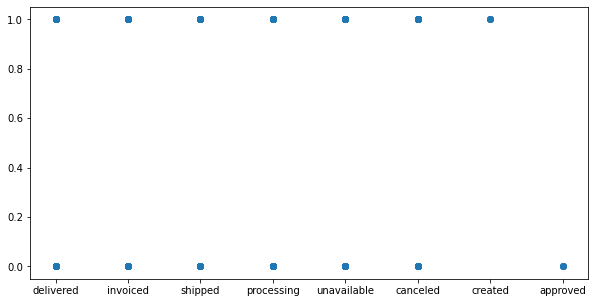

In [1759]:
plt.figure(figsize=(10,5))
plt.scatter(df_orders_translated['order_status'], df_orders_translated['product_category_name_english'].isna())
plt.show()

In [1760]:
df_orders_translated[df_orders_translated['order_status'] == 'delivered'].shape[0]/ df_orders_translated.shape[0] * 100

97.22038833307941

We can see that orders with delivered status represent about 97% of all orders. As the dates for these orders are Null we can safely delete these order entries as they represent less than 3% of the data.

In [1761]:
df_orders_translated = df_orders_translated[df_orders_translated['order_status'] == 'delivered']

In [1762]:
df_orders_translated.shape

(114862, 43)

Duplicates?

In [1763]:
df_orders_translated.duplicated().any()

False

In [1764]:
df_orders_translated.transpose().duplicated().any()

False

There are no either duplicated rows nor duplicated column on our dataframe.

Let us look at Null data.

 Get the dataframe summary:

In [1765]:
df_orders_translated.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
order_item_id,114862.0,1.194607,0.685732,1.000000,1.000000,1.000000,1.000000,21.000000
price,114862.0,119.772174,181.422029,0.850000,39.900000,74.900000,132.900000,6735.000000
freight_value,114862.0,19.974091,15.703281,0.000000,13.080000,16.280000,21.150000,409.680000
payment_sequential,114859.0,1.091564,0.688852,1.000000,1.000000,1.000000,1.000000,26.000000
payment_installments,114859.0,2.937837,2.773738,0.000000,1.000000,2.000000,4.000000,24.000000
payment_value,114859.0,171.255856,263.764568,0.000000,60.720000,108.000000,188.690000,13664.080000
customer_zip_code_prefix,114862.0,35085.104064,29874.422091,1003.000000,11250.000000,24310.000000,58884.000000,99980.000000
review_score,114862.0,4.080488,1.347659,1.000000,4.000000,5.000000,5.000000,5.000000
product_name_lenght,113236.0,48.804665,10.015609,5.000000,42.000000,52.000000,57.000000,76.000000
product_description_lenght,113236.0,784.755793,650.268562,4.000000,346.000000,600.000000,983.000000,3992.000000


Ok, so an average order would have a price of 120, fright value of 20 (14% of the total cost), 3 installments, review score of 4, name and description lengths of 48 and 785 characters, 2 images, weights around 2 Kg, 30 X 17 X 23 cm in size.

It is striking to see that the price for some items went as high as 6735 compared to the average of 120, however this seems to be an outlier as the price std is 182.

Also, the looking at the payment installments, the average buyer buys the product in ~ 3 installments.

As for the score, an average of 4 out of 5 is high but is not surprising.

It is interesting to see that most orders / products had 2 images only. It is also interesting to see that the average weight is around 2 Kg, no wonder that average cost of fright is ~14% of the total item cost - fright inclusive.

Looking at the mean customers and the sellers geolocations, it appears that they are centered differently, which makes sense if the sellers are centered around the Brazilian capital while the customers are scattered around the country.

The Graph below shows the missing values in each column of our dataframe (be reminded that few steps back we got rid of most of the Null data row-wise).The dashed vertical line represents the 3% limit of missing data. It is clear that the data is in good shape as the majority of columns are only missing a far lower percentage than 3%. some a lit close and off course with the exception of the review title and review message columns that are missing more than 60 percent of the data. It will be wise to omit these two columns.

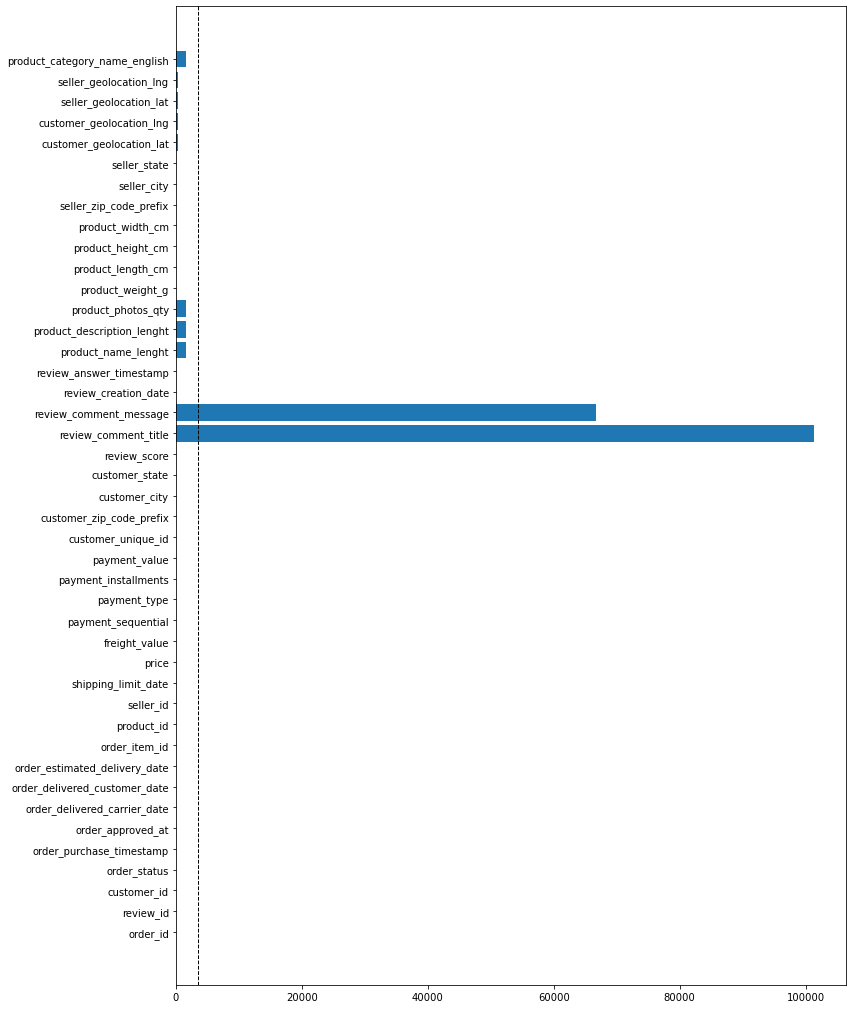

In [1766]:
plt.figure(figsize=(12, 18))
plt.barh( df_orders_translated.columns.tolist(), df_orders_translated.isna().sum().tolist())
plt.axvline((df_orders_translated.shape[0]*0.03), color='k', linestyle='dashed', linewidth=1)
plt.show()

Remove columns:'review_comment_title','review_comment_message'

In [1767]:
df_orders_translated = df_orders_translated.drop(['review_comment_title','review_comment_message'], axis = 1)

In [1768]:
df_orders_translated.shape, print('review_comment_title and review_comment_message columns removed.')

review_comment_title and review_comment_message columns removed.


((114862, 41), None)

As of the other columns that have null values, let us look at them one by one and see whether we need to delete the respective Null rows or impute them if necessary and possible.

In [1769]:
df_orders_translated.isna().sum()

order_id                            0
review_id                           0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date        2
order_delivered_customer_date       8
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
review_score                        0
review_creation_date                0
review_answer_timestamp             0
product_name

In [1770]:
df_orders_translated[df_orders_translated['product_name_lenght'].isna()].sample(3)       

,order_id,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english
45819,5312f3d56a531aaf51a7b9b3e38905cf,bebc43af8958c47f3cbb8a6c0a1834bd,e66cf38a4613e6c515fa66440545edfd,delivered,2017-11-27 21:54:52,2017-11-27 22:17:48,2017-12-04 11:09:34,2017-12-05 18:03:14,2017-12-18 00:00:00,1.0,8be128ce3f51211048f4b891e9303381,46dc3b2cc0980fb8ec44634e21d2718e,2017-12-03 22:17:48,259.99,19.26,1.0,credit_card,1.0,279.25,ff16d29e19b92c63503939641cb423da,28800,rio bonito,RJ,5,2017-12-06 00:00:00,2017-12-07 23:31:01,NaN,NaN,NaN,3300.0,28.0,20.0,40.0,22240.0,rio de janeiro,RJ,-22.711928,-42.630041,-22.935263,-43.187264,NaN
99509,99d4cf1fbaf4104549feed3c138f63f7,6c3c9ada6c8e944efcbfaf633e003248,a0ba455ec2854970e286ce33e4823416,delivered,2018-01-25 22:32:50,2018-01-25 22:56:57,2018-01-29 17:27:06,2018-02-08 23:51:53,2018-02-23 00:00:00,1.0,bb1c86c0b1cd8da99fbd48d798abcca0,f419677537694f0462a91990df6ca44f,2018-01-31 22:56:57,29.95,17.92,2.0,voucher,1.0,11.85,fda1438f0badd2e3724bd6c459e1cf68,44052,feira de santana,BA,3,2018-02-09 00:00:00,2018-02-12 10:38:48,NaN,NaN,NaN,830.0,19.0,6.0,26.0,9750.0,sao bernardo do campo,SP,-12.244609,-38.943747,-23.688119,-46.553222,NaN
38280,0de497b1f069927c15c241a833bb67d0,c90cd8ac72188db11d80723b01e175d1,49a385b4c7bfe2a0c2e12220bb169dab,delivered,2017-07-11 11:56:29,2017-07-11 12:23:45,2017-07-14 17:51:37,2017-07-26 18:43:53,2017-08-04 00:00:00,1.0,b8c2cf7e813b0eb7ec62f7459217b22c,25c5c91f63607446a97b143d2d535d31,2017-07-19 12:23:45,320.00,19.49,1.0,credit_card,1.0,339.49,7725ee39818a24b0127ee4d6a6fba237,4363,sao paulo,SP,5,2017-07-27 00:00:00,2017-07-28 12:14:39,NaN,NaN,NaN,1800.0,40.0,23.0,13.0,35680.0,itauna,MG,-23.646505,-46.666226,-20.077863,-44.576134,NaN


Checking the instances where the product_name_lenght, product_description_lenght, and product_photos_qt are Null, it appears to be a sort of corruption in the data as it is unlikely to get products sold without at least a name. These columns will surely not be removed later, so it will be wise to remove the Null-value instances from the dataframe as they represent less that ~1% of the instances. 

In [1771]:
df_orders_translated = df_orders_translated[~df_orders_translated['product_name_lenght'].isna()]

In [1772]:
df_orders_translated.shape

(113236, 41)

Checking the remaining Null values.

In [1773]:
df_orders_translated.T.isna().any().sum()

606

In [1774]:
df_orders_translated.isna().sum()

order_id                           0
review_id                          0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                 14
order_delivered_carrier_date       2
order_delivered_customer_date      8
order_estimated_delivery_date      0
order_item_id                      0
product_id                         0
seller_id                          0
shipping_limit_date                0
price                              0
freight_value                      0
payment_sequential                 3
payment_type                       3
payment_installments               3
payment_value                      3
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
review_score                       0
review_creation_date               0
review_answer_timestamp            0
product_name_lenght                0
p

We will go ahead and remove the the rest for the same reason.

In [1775]:
df_orders_translated = df_orders_translated[~df_orders_translated.T.isna().any()]

In [1776]:
df_orders_translated.shape

(112630, 41)

Now let us look at the columns datatypes. 

In [1777]:
df_orders_translated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112630 entries, 0 to 118145
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112630 non-null  object 
 1   review_id                      112630 non-null  object 
 2   customer_id                    112630 non-null  object 
 3   order_status                   112630 non-null  object 
 4   order_purchase_timestamp       112630 non-null  object 
 5   order_approved_at              112630 non-null  object 
 6   order_delivered_carrier_date   112630 non-null  object 
 7   order_delivered_customer_date  112630 non-null  object 
 8   order_estimated_delivery_date  112630 non-null  object 
 9   order_item_id                  112630 non-null  float64
 10  product_id                     112630 non-null  object 
 11  seller_id                      112630 non-null  object 
 12  shipping_limit_date           

In [1778]:
df_orders_translated.head(1)

,order_id,review_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4,2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,-23.576983,-46.587161,-23.680729,-46.444238,housewares


There is some work to be done here, there are several columns that need data type change:
- All date and datatime columns need to be changed:
    - order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, shipping_limit_date, review_creation_date, and review_answer_timestamp
- Many integer data type like columns has float data type that needs to be changes:
    - order_item_id, payment_sequential, payment_installments, product_photos_qty, customer_zip_code_prefix, and seller_zip_code_prefix

In [1779]:
df_list = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
           'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']
df_orders_translated[df_list] = df_orders_translated[df_list].astype('datetime64[ns]')

In [1780]:
# We will leave customer_zip_code_prefix, and seller_zip_code_prefix our for now as they will be treated differentlly
df_list = ['order_item_id', 'payment_sequential', 'payment_installments', 'product_photos_qty']
df_orders_translated[df_list] = df_orders_translated[df_list].astype(int, errors='ignore')

In [1781]:
df_orders_translated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112630 entries, 0 to 118145
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112630 non-null  object        
 1   review_id                      112630 non-null  object        
 2   customer_id                    112630 non-null  object        
 3   order_status                   112630 non-null  object        
 4   order_purchase_timestamp       112630 non-null  datetime64[ns]
 5   order_approved_at              112630 non-null  datetime64[ns]
 6   order_delivered_carrier_date   112630 non-null  datetime64[ns]
 7   order_delivered_customer_date  112630 non-null  datetime64[ns]
 8   order_estimated_delivery_date  112630 non-null  datetime64[ns]
 9   order_item_id                  112630 non-null  int32         
 10  product_id                     112630 non-null  object        
 11  

##### Transform the data into a customer level  & Omit all irrelevant features

Now, we want to get our dataframe into the customer level instead of the order level. First we need to remember that we may have many rows with identical customer_id due to:
- some customers may have ordered more than one item / order
- Some orders have more than one shipment

That means we need to find a way of getting the data into the customer level in the best way possible.
So let us have a look again at the dataframe from the perspective of customer_id.

In [1782]:
df_orders_translated['customer_id'].value_counts()

270c23a11d024a44c896d1894b261a83    63
13aa59158da63ba0e93ec6ac2c07aacb    38
92cd3ec6e2d643d4ebd0e3d6238f69e2    26
d22f25a9fadfb1abbc2e29395b1239f4    24
6ee2f17e3b6c33d6a9557f280edd2925    24
                                    ..
37477516d7b6f959ce137f49f1842a72     1
e53d099c01ad635b7dca18573d4ab1ad     1
fd07331c4101d0fdb0a32655958da8d5     1
74286e84c53dc33b9ea00c5b20274a5e     1
edb027a75a1449115f6b43211ae02a24     1
Name: customer_id, Length: 93996, dtype: int64

In [1783]:
print(f' Orders with unique customers represent {(df_orders_translated["customer_id"].nunique()/df_orders_translated.shape[0] * 100):2.2f} % of the total orders.')

 Orders with unique customers represent 83.46 % of the total orders.


In [1784]:
print(f' Single order instance customers represent {((df_orders_translated["customer_id"].value_counts() < 2).sum()/df_orders_translated.shape[0] * 100):2.2f} % of the total orders.')

 Single order instance customers represent 72.54 % of the total orders.


In [1785]:
df_orders_translated['customer_id'].unique()

array(['9ef432eb6251297304e76186b10a928d',
       'b0830fb4747a6c6d20dea0b8c802d7ef',
       '41ce2a54c0b03bf3443c3d931a367089', ...,
       '1aa71eb042121263aafbe80c1b562c9c',
       'b331b74b18dc79bcdf6532d51e1637c1',
       'edb027a75a1449115f6b43211ae02a24'], dtype=object)

There are around 72% of of orders that have been undertaken by single time buyers (or rather single order instance) while the rest of 28% have been undertaken by more-than-one-time buyers. This means that the frequent buyers subcategory is a significant one (frequent buyers are those buying more than once in the lifetime of this dataset).

In [1786]:
len(df_orders_translated['customer_id'].unique())

93996

Now, we need to reduce our dataframe to 93,996 customer. This is straight forward for all the so-called single buyers instances as each order instance represents a customer instance. The part that need some manipulation is the 28% portion of the dataframe.

To reduce more than one order instance into one customer instance, we need to examine our columns again and find a way to summarize the instances without losing information, or rather retain as much information as possible.

It will be wise at this stage to drop *some* unnecessary columns that are either represented by other columns or do not seem to be relevant.

Before moving on, it will be helping if we rearrange some columns, namely:
- transform the dimensions into volume
- transform the dates into periods

In [1787]:
df_orders_translated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112630 entries, 0 to 118145
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112630 non-null  object        
 1   review_id                      112630 non-null  object        
 2   customer_id                    112630 non-null  object        
 3   order_status                   112630 non-null  object        
 4   order_purchase_timestamp       112630 non-null  datetime64[ns]
 5   order_approved_at              112630 non-null  datetime64[ns]
 6   order_delivered_carrier_date   112630 non-null  datetime64[ns]
 7   order_delivered_customer_date  112630 non-null  datetime64[ns]
 8   order_estimated_delivery_date  112630 non-null  datetime64[ns]
 9   order_item_id                  112630 non-null  int32         
 10  product_id                     112630 non-null  object        
 11  

##### Transform dimensions into volume

In [1788]:
# Transform dimensions into volum3 cm^3
df_orders_translated['order_volume'] = df_orders_translated['product_length_cm'] * \
df_orders_translated['product_height_cm'] * \
df_orders_translated['product_width_cm']

In [1789]:
# drop the three columns
df_orders_translated.drop(columns = ['product_length_cm', 'product_height_cm', 'product_width_cm'], inplace = True)

##### Transform the dates into periods

We will use the purchase date `order_purchase_timestamp` as the reference and calculate the period in days for other columns to the reference. It seems that the `order_approved_at` is always few hour after the reference which will lead to a Zero-value but we will check this after the transformation. 

The columns are: \
order_purchase_timestamp  
order_approved_at            
order_delivered_carrier_date  
order_delivered_customer_date   
order_estimated_delivery_date  
shipping_limit_date  
review_creation_date   
review_answer_timestamp  

In [1790]:
# transform the dates into periods
date_list = ['order_purchase_timestamp',
'order_approved_at',
'order_delivered_carrier_date',
'order_delivered_customer_date',
'order_estimated_delivery_date',
'shipping_limit_date',
'review_creation_date',
'review_answer_timestamp']

df_orders_translated[date_list] = df_orders_translated[date_list].apply\
(lambda x: (pd.to_datetime(x) - pd.to_datetime(df_orders_translated['order_purchase_timestamp']))\
 //np.timedelta64(1, 'D'))

In [1791]:
# delete the refernce columns
df_orders_translated.drop(columns = 'order_purchase_timestamp', inplace = True)

In [1792]:
df_orders_translated.sample(2)

,order_id,review_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english,order_volume
30008,5eeb092ebe54bc6f635f566588d2e908,23e7efab08692246c8e0585d87e1fc1a,b67e09339b0e590a3e6dd7c502badc8f,delivered,0,3,8,25,1,7e93d6b6ef018d488da72952ce48fb9a,46dc3b2cc0980fb8ec44634e21d2718e,4,269.99,29.27,1,credit_card,4,299.26,168b650549ccf26c55e7040bce0ad370,99060,passo fundo,RS,5,9,10,53.0,735.0,2,2800.0,22240.0,rio de janeiro,RJ,-28.275845,-52.375008,-22.935263,-43.187264,sports_leisure,20880.0
36458,387d33b2be3d1d8dd063941d1b57d3fb,3ffed17f5010b9c6d33706b790732482,a3631211bc272aaab72fad2aa11125f9,delivered,0,27,32,40,2,f3fddc967610429e8ee3cf2d089817bf,a2e874074c877c5a05abae80ad6e488f,27,7.96,11.85,1,credit_card,2,39.62,1abb39330620468379baa8d035a9cca2,4302,sao paulo,SP,1,32,33,31.0,137.0,1,150.0,15070.0,sao jose do rio preto,SP,-23.621975,-46.636790,-20.818007,-49.362320,housewares,2592.0


Let us also delete the following columns as they are not needed any more:
- `order_status`: we deleted all non-delivered rows earlier
- `customer_zip_code_prefix`,  `seller_zip_code_prefix`, `customer_city`, `customer_state`, `seller_city`, `seller_state`: we have Lat and Long in the dataframe instead 
- `seller_geolocation_lat`, `seller_geolocation_lng`: this will make reducing the dataframe down to the customer level easier             

In [1793]:
# delete columns
to_delete = ['order_status', 'customer_zip_code_prefix', 'seller_zip_code_prefix', \
            'customer_city', 'customer_state', 'seller_city', 'seller_state', \
             'seller_geolocation_lat', 'seller_geolocation_lng']
df_orders_translated.drop(columns = to_delete, inplace = True)

In [1794]:
df_orders_translated.shape

(112630, 29)

In [1795]:
df_orders_translated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112630 entries, 0 to 118145
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112630 non-null  object 
 1   review_id                      112630 non-null  object 
 2   customer_id                    112630 non-null  object 
 3   order_approved_at              112630 non-null  int64  
 4   order_delivered_carrier_date   112630 non-null  int64  
 5   order_delivered_customer_date  112630 non-null  int64  
 6   order_estimated_delivery_date  112630 non-null  int64  
 7   order_item_id                  112630 non-null  int32  
 8   product_id                     112630 non-null  object 
 9   seller_id                      112630 non-null  object 
 10  shipping_limit_date            112630 non-null  int64  
 11  price                          112630 non-null  float64
 12  freight_value                 

Let us take few examples of these instances with a common customer_id starting by the most frequent buyer '270c23a11d024a44c896d1894b261a83' with a record of 63 instances, and let us analyze it:

In [1796]:
df_orders_translated[df_orders_translated['customer_id'] == '270c23a11d024a44c896d1894b261a83']

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84816,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,17,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84817,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,1,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84818,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,13,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84819,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,16,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84820,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,19,voucher,1,0.24,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84874,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,15,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84875,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,20,voucher,1,4.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84876,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,14,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84877,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,9,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


In [1797]:
df_orders_translated[df_orders_translated['customer_id'] == '270c23a11d024a44c896d1894b261a83'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
order_approved_at,63.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
order_delivered_carrier_date,63.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000
order_delivered_customer_date,63.0,5.000000,0.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000
order_estimated_delivery_date,63.0,21.000000,0.000000e+00,21.000000,21.000000,21.000000,21.000000,21.000000
order_item_id,63.0,2.000000,8.230549e-01,1.000000,1.000000,2.000000,3.000000,3.000000
shipping_limit_date,63.0,6.000000,0.000000e+00,6.000000,6.000000,6.000000,6.000000,6.000000
price,63.0,36.593333,3.364827e+01,12.990000,12.990000,12.990000,83.800000,83.800000
freight_value,63.0,17.180000,8.596205e+00,5.120000,5.120000,23.210000,23.210000,23.210000
payment_sequential,63.0,11.000000,6.103938e+00,1.000000,6.000000,11.000000,16.000000,21.000000
payment_installments,63.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


Some striking observations about this buyer:
- they tend to buy less expensive products compared to the average person of 120
- although they bought all their orders in one installment and buy inexpensive products, they tended to use an average of 11 different payment methods per order, this is not normal
- they scored 5 all the time, a very satisfied buyer indeed
- The products they bought have more weight than average

The question is, for such a buyer, how can we capture this information in one row without distorting the information we have?

Looking at the dataframe above we can also notice the following:


In [1798]:
df_orders_translated.head()

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
0,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
1,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
2,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
3,53cdb2fc8bc7dce0b6741e2150273451,8d5266042046a06655c8db133d120ba5,b0830fb4747a6c6d20dea0b8c802d7ef,1,1,13,19,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,5,118.70,22.76,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,4,14,14,29.0,178.0,1,400.0,-12.177924,-44.660711,perfumery,4693.0
4,47770eb9100c2d0c44946d9cf07ec65d,e73b67b67587f7644d5bd1a52deb1b01,41ce2a54c0b03bf3443c3d931a367089,0,0,9,26,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,5,159.90,19.22,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,5,9,14,46.0,232.0,1,420.0,-16.745150,-48.514783,auto,9576.0


In [1799]:
df_orders_translated[df_orders_translated['customer_id'] == '270c23a11d024a44c896d1894b261a83']['order_id'].unique()

array(['895ab968e7bb0d5659d16cd74cd1650c'], dtype=object)

This is one order only!!!!!!!!!!!!!!!!!!!!!!!!!!!

This does not look right, let us see the order_item_id column to understand more.

In [1800]:
df_orders_translated[df_orders_translated['customer_id'] == 
                     '270c23a11d024a44c896d1894b261a83']['order_item_id'].value_counts()

1    21
2    21
3    21
Name: order_item_id, dtype: int64

In [1801]:
df_orders_translated[df_orders_translated['customer_id'] == 
                     '270c23a11d024a44c896d1894b261a83']['payment_sequential'].value_counts()

17    3
11    3
9     3
14    3
20    3
15    3
7     3
10    3
5     3
3     3
8     3
1     3
18    3
12    3
2     3
21    3
4     3
19    3
16    3
13    3
6     3
Name: payment_sequential, dtype: int64

It is clear now as to why this customer has 63 records on the dataframe that looked initially to me as 63 possible orders (if we do not consider the order_id column), the reasons are that:
- the order has been sent in 3 shipments
- every shipment is associated with 21 payment methods

This sum up to 3 X 21 = 63 records

Let us confirm this by looking at the product_category_name_english column.

In [1802]:
df_orders_translated[df_orders_translated['customer_id'] == 
                     '270c23a11d024a44c896d1894b261a83']['product_category_name_english'].value_counts() 

bed_bath_table    42
housewares        21
Name: product_category_name_english, dtype: int64

hmmmmm...

In [1803]:
df_orders_translated[df_orders_translated['customer_id'] == 
                     '270c23a11d024a44c896d1894b261a83']['seller_id'].value_counts()

822166ed1e47908f7cfb49946d03c726    42
3d0cd21d41671c46f82cd11176bf7277    21
Name: seller_id, dtype: int64

In [1804]:
df_orders_translated[df_orders_translated['customer_id'] == 
                     '270c23a11d024a44c896d1894b261a83']['order_delivered_customer_date'].value_counts()

5    63
Name: order_delivered_customer_date, dtype: int64

In [1805]:
df_orders_translated[df_orders_translated['customer_id'] == 
                     '270c23a11d024a44c896d1894b261a83']['product_id'].value_counts()

ebf9bc6cd600eadd681384e3116fda85    42
5ddab10d5e0a23acb99acf56b62b3276    21
Name: product_id, dtype: int64

In [1806]:
df_orders_translated[df_orders_translated['customer_id'] == '270c23a11d024a44c896d1894b261a83'].groupby('payment_sequential').apply(display)

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84817,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,1,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84838,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,1,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84859,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,1,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84823,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,2,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84844,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,2,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84865,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,2,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84828,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,3,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84849,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,3,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84870,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,3,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84821,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,4,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84842,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,4,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84863,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,4,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84829,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,5,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84850,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,5,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84871,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,5,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84836,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,6,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84857,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,6,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84878,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,6,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84831,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,7,voucher,1,2.6,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84852,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,7,voucher,1,2.6,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84873,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,7,voucher,1,2.6,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84826,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,8,voucher,1,0.41,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84847,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,8,voucher,1,0.41,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84868,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,8,voucher,1,0.41,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84835,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,9,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84856,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,9,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84877,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,9,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84830,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,10,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84851,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,10,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84872,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,10,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84827,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,11,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84848,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,11,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84869,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,11,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84824,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,12,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84845,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,12,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84866,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,12,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84818,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,13,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84839,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,13,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84860,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,13,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84834,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,14,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84855,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,14,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84876,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,14,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84832,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,15,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84853,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,15,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84874,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,15,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84819,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,16,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84840,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,16,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84861,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,16,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84816,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,17,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84837,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,17,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84858,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,17,voucher,1,16.7,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84825,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,18,voucher,1,1.31,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84846,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,18,voucher,1,1.31,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84867,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,18,voucher,1,1.31,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84820,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,19,voucher,1,0.24,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84841,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,19,voucher,1,0.24,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84862,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,19,voucher,1,0.24,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84833,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,20,voucher,1,4.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84854,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,20,voucher,1,4.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84875,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,20,voucher,1,4.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84822,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,21,voucher,1,0.28,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84843,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,21,voucher,1,0.28,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84864,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,21,voucher,1,0.28,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


""


So, 3 items shopped to this customer, 2 items (bed_bath_table category) form one seller and 1 item (housewares category) from another seller. Each one of these items is associated with one payment_sequential.

The order items have been purchased at the same time and received by the customer at the same time 6 days later.

In [1807]:
df_orders_translated[df_orders_translated['customer_id'] == '270c23a11d024a44c896d1894b261a83'].groupby('order_item_id').apply(display)

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84816,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,17,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84817,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,1,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84818,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,13,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84819,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,16,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84820,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,19,voucher,1,0.24,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84821,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,4,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84822,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,21,voucher,1,0.28,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84823,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,2,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84824,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,12,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84825,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,18,voucher,1,1.31,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84837,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,17,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84838,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,1,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84839,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,13,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84840,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,16,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84841,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,19,voucher,1,0.24,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84842,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,4,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84843,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,21,voucher,1,0.28,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84844,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,2,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84845,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,12,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84846,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,18,voucher,1,1.31,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0


,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84858,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,17,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84859,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,1,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84860,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,13,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84861,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,16,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84862,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,19,voucher,1,0.24,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84863,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,4,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84864,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,21,voucher,1,0.28,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84865,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,2,voucher,1,2.61,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84866,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,12,voucher,1,16.70,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0
84867,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.8,5.12,18,voucher,1,1.31,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


""


On the objective of reducing the this data to one one instance, we can:
1. group by order_item_id and get the sum of payment_value and store it as payment_value
2. group by order_item_id and get the max of payment_sequential and store it as payment_sequential
Every other column value is just a duplicate of other instances in the same group by.

In [1808]:
# df_temp = df_orders_translated[df_orders_translated['customer_id'] == '270c23a11d024a44c896d1894b261a83'].copy()
df_orders_translated['payment_value'] = df_orders_translated.groupby(['order_id','order_item_id'])['payment_value'].transform('sum')

In [1809]:
# df_orders_translated.groupby('order_item_id').apply(display)

In [1810]:
df_orders_translated['payment_sequential'] = df_orders_translated.groupby(['order_id','order_item_id'])['payment_sequential'].transform('max')

In [1811]:
# df_orders_translated.groupby('order_item_id').apply(display)

In [1812]:
df_orders_translated.duplicated().sum()

2194

This two groupby operations takes us down to 3 rows instead of the 63.

In [1813]:
df_orders_translated[~df_orders_translated.duplicated()]

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
0,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,3,credit_card,1,38.71,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
1,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,3,voucher,1,38.71,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
3,53cdb2fc8bc7dce0b6741e2150273451,8d5266042046a06655c8db133d120ba5,b0830fb4747a6c6d20dea0b8c802d7ef,1,1,13,19,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,5,118.70,22.76,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,4,14,14,29.0,178.0,1,400.0,-12.177924,-44.660711,perfumery,4693.0
4,47770eb9100c2d0c44946d9cf07ec65d,e73b67b67587f7644d5bd1a52deb1b01,41ce2a54c0b03bf3443c3d931a367089,0,0,9,26,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,5,159.90,19.22,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,5,9,14,46.0,232.0,1,420.0,-16.745150,-48.514783,auto,9576.0
5,949d5b44dbf5de918fe9c16f97b45f8a,359d03e676b3c069f62cadba8dd3f6e8,f88197465ea7920adcdbec7375364d82,0,3,13,26,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,5,45.00,27.20,1,credit_card,1,72.20,7c142cf63193a1473d2e66489a9ae977,5,14,16,59.0,468.0,3,450.0,-5.774190,-35.271143,pet_shop,6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118141,63943bddc261676b46f01ca7ac2f7bd8,29bb71b2760d0f876dfa178a76bc4734,1fca14ff2861355f6e5f14306ff977a7,0,1,22,23,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,6,174.90,20.10,1,credit_card,3,195.00,da62f9e57a76d978d02ab5362c509660,4,22,24,52.0,828.0,4,4950.0,-24.001500,-46.449864,baby,16000.0
118142,83c1379a015df1e13d02aae0204711ab,371579771219f6db2d830d50805977bb,1aa71eb042121263aafbe80c1b562c9c,0,1,24,30,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,9,205.99,65.02,1,credit_card,5,271.01,737520a9aad80b3fbbdad19b66b37b30,5,25,26,51.0,500.0,2,13300.0,-17.898358,-39.373630,home_appliances_2,63360.0
118143,11c177c8e97725db2631073c19f07b62,8ab6855b9fe9b812cd03a480a25058a1,b331b74b18dc79bcdf6532d51e1637c1,0,3,17,37,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,4,179.99,40.59,1,credit_card,4,441.16,5097a5312c8b157bb7be58ae360ef43c,2,17,18,59.0,1893.0,1,6550.0,-22.562825,-42.694574,computers_accessories,8000.0
118144,11c177c8e97725db2631073c19f07b62,8ab6855b9fe9b812cd03a480a25058a1,b331b74b18dc79bcdf6532d51e1637c1,0,3,17,37,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,4,179.99,40.59,1,credit_card,4,441.16,5097a5312c8b157bb7be58ae360ef43c,2,17,18,59.0,1893.0,1,6550.0,-22.562825,-42.694574,computers_accessories,8000.0


Delete the duplicated:


In [1814]:
df_orders_translated.drop_duplicates(inplace = True)

In [1815]:
df_orders_translated.head()

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
0,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,3,credit_card,1,38.71,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
1,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,3,voucher,1,38.71,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
3,53cdb2fc8bc7dce0b6741e2150273451,8d5266042046a06655c8db133d120ba5,b0830fb4747a6c6d20dea0b8c802d7ef,1,1,13,19,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,5,118.70,22.76,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,4,14,14,29.0,178.0,1,400.0,-12.177924,-44.660711,perfumery,4693.0
4,47770eb9100c2d0c44946d9cf07ec65d,e73b67b67587f7644d5bd1a52deb1b01,41ce2a54c0b03bf3443c3d931a367089,0,0,9,26,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,5,159.90,19.22,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,5,9,14,46.0,232.0,1,420.0,-16.745150,-48.514783,auto,9576.0
5,949d5b44dbf5de918fe9c16f97b45f8a,359d03e676b3c069f62cadba8dd3f6e8,f88197465ea7920adcdbec7375364d82,0,3,13,26,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,5,45.00,27.20,1,credit_card,1,72.20,7c142cf63193a1473d2e66489a9ae977,5,14,16,59.0,468.0,3,450.0,-5.774190,-35.271143,pet_shop,6000.0


In [1816]:
# df_orders_translated.groupby('product_id').apply(display)

Now we need to group by the product_id and get the total number of order_item_id.

In [1817]:
df_orders_translated['order_item_id'] = df_orders_translated.groupby(['order_id','product_id'])['order_item_id'].transform('max')

In [1818]:
# df_orders_translated.groupby('product_id').apply(display)

Drop duplicates again.

In [1819]:
df_orders_translated.drop_duplicates(inplace = True)

In [1820]:
df_orders_translated.head()

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
0,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,3,credit_card,1,38.71,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
1,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,9ef432eb6251297304e76186b10a928d,0,2,8,15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,4,29.99,8.72,3,voucher,1,38.71,7c396fd4830fd04220f754e42b4e5bff,4,8,9,40.0,268.0,4,500.0,-23.576983,-46.587161,housewares,1976.0
3,53cdb2fc8bc7dce0b6741e2150273451,8d5266042046a06655c8db133d120ba5,b0830fb4747a6c6d20dea0b8c802d7ef,1,1,13,19,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,5,118.70,22.76,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,4,14,14,29.0,178.0,1,400.0,-12.177924,-44.660711,perfumery,4693.0
4,47770eb9100c2d0c44946d9cf07ec65d,e73b67b67587f7644d5bd1a52deb1b01,41ce2a54c0b03bf3443c3d931a367089,0,0,9,26,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,5,159.90,19.22,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,5,9,14,46.0,232.0,1,420.0,-16.745150,-48.514783,auto,9576.0
5,949d5b44dbf5de918fe9c16f97b45f8a,359d03e676b3c069f62cadba8dd3f6e8,f88197465ea7920adcdbec7375364d82,0,3,13,26,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,5,45.00,27.20,1,credit_card,1,72.20,7c142cf63193a1473d2e66489a9ae977,5,14,16,59.0,468.0,3,450.0,-5.774190,-35.271143,pet_shop,6000.0


In [1821]:
df_orders_translated[df_orders_translated['customer_id'] == '270c23a11d024a44c896d1894b261a83']

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,product_category_name_english,order_volume
84816,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,6,12.99,23.21,21,voucher,1,161.32,9a736b248f67d166d2fbb006bcb877c3,5,6,9,37.0,86.0,2,1300.0,-23.586366,-46.571079,bed_bath_table,18450.0
84858,895ab968e7bb0d5659d16cd74cd1650c,eef5dbca8d37dfce6db7d7b16dd0525e,270c23a11d024a44c896d1894b261a83,0,1,5,21,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,6,83.80,5.12,21,voucher,1,161.32,9a736b248f67d166d2fbb006bcb877c3,5,6,9,56.0,548.0,8,450.0,-23.586366,-46.571079,housewares,6600.0


Now we reduced our data down from 63 rows to two rows per order item product_id each. 

How can we reduce it even further to one row? 

We can do so by averaging all number and on-hot-encoding the `payment_type` and the `product_category_name_english` columns. This will result in a sparse dataframe and an addition of north of 70 columns.

In [1822]:
df_orders_translated.shape

(100510, 29)

- order_id                       : mean()   
- review_id                      : mean()  
- customer_id                    : -   
- order_approved_at              : mean()       
- order_delivered_carrier_date   : mean()    
- order_delivered_customer_date  : mean()   
- order_estimated_delivery_date  : mean()   
- order_item_id                  : max()   
- product_id                     : nunique()   
- seller_id                      : nunique()     
- shipping_limit_date            : mean()       
- price                          : mean()       
- freight_value                  : mean()       
- payment_sequential             : max()      
- payment_type                   : one-hot-encoding, then sum()
- payment_installments           : max()          
- payment_value                  : mean()     
- customer_unique_id             : -   
- review_score                   : mean()       
- review_creation_date           : mean()       
- review_answer_timestamp        : mean()      
- product_name_lenght            : mean()    
- product_description_lenght     : mean()      
- product_photos_qty             : mean()       
- product_weight_g               : mean()      
- customer_geolocation_lat       : -      
- customer_geolocation_lng       : -  
- product_category_name_english  : one-hot-encoding, then sum()
- order_volume                   : mean()     

In [1823]:
df_orders_translated['payment_type'].nunique()

4

In [1824]:
df_orders_translated['product_category_name_english'].nunique()

71

Let us start by the one hot encoding for the following by using get_dummies:
- payment_type                   : one-hot-encoding   
- product_category_name_english  : one-hot-encoding  

we will expect an addition of 75 - 2 columns.

In [1825]:
df_orders_translated.shape

(100510, 29)

In [1826]:
df_orders_translated = pd.get_dummies(df_orders_translated, columns = ['payment_type', 'product_category_name_english'])

In [1827]:
df_orders_translated.shape

(100510, 102)

In [1828]:
df_orders_translated.sample(1)

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,order_volume,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,product_category_name_english_agro_industry_and_commerce,product_category_name_english_air_conditioning,product_category_name_english_art,product_category_name_english_arts_and_craftmanship,product_category_name_english_audio,product_category_name_english_auto,product_category_name_english_baby,product_category_name_english_bed_bath_table,product_category_name_english_books_general_interest,product_category_name_english_books_imported,product_category_name_english_books_technical,product_category_name_english_cds_dvds_musicals,product_category_name_english_christmas_supplies,product_category_name_english_cine_photo,product_category_name_english_computers,product_category_name_english_computers_accessories,product_category_name_english_consoles_games,product_category_name_english_construction_tools_construction,product_category_name_english_construction_tools_lights,product_category_name_english_construction_tools_safety,product_category_name_english_cool_stuff,product_category_name_english_costruction_tools_garden,product_category_name_english_costruction_tools_tools,product_category_name_english_diapers_and_hygiene,product_category_name_english_drinks,product_category_name_english_dvds_blu_ray,product_category_name_english_electronics,product_category_name_english_fashio_female_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_fashion_childrens_clothes,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_shoes,product_category_name_english_fashion_sport,product_category_name_english_fashion_underwear_beach,product_category_name_english_fixed_telephony,product_category_name_english_flowers,product_category_name_english_food,product_category_name_english_food_drink,product_category_name_english_furniture_bedroom,product_category_name_english_furniture_decor,product_category_name_english_furniture_living_room,product_category_name_english_furniture_mattress_and_upholstery,product_category_name_english_garden_tools,product_category_name_english_health_beauty,product_category_name_english_home_appliances,product_category_name_english_home_appliances_2,product_category_name_english_home_comfort_2,product_category_name_english_home_confort,product_category_name_english_home_construction,product_category_name_english_housewares,product_category_name_english_industry_commerce_and_business,product_category_name_english_kitchen_dining_laundry_garden_furniture,product_category_name_english_la_cuisine,product_category_name_english_luggage_accessories,product_category_name_english_market_place,product_category_name_english_music,product_category_name_english_musical_instruments,product_category_name_english_office_furniture,product_category_name_english_party_supplies,product_category_name_english_perfumery,product_category_name_english_pet_shop,product_category_name_english_security_and_services,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
97818,98c0f6e16f786f293db2cdf5388442f6,4bd99bd23412c408607cd56a9858cffd,b34c2

Now we can perform the groupby operations.

In [1829]:
df_orders_translated.columns

Index(['order_id', 'review_id', 'customer_id', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id',
       ...
       'product_category_name_english_security_and_services',
       'product_category_name_english_signaling_and_security',
       'product_category_name_english_small_appliances',
       'product_category_name_english_small_appliances_home_oven_and_coffee',
       'product_category_name_english_sports_leisure',
       'product_category_name_english_stationery',
       'product_category_name_english_tablets_printing_image',
       'product_category_name_english_telephony',
       'product_category_name_english_toys',
       'product_category_name_english_watches_gifts'],
      dtype='object', length=102)

In [1830]:
len(df_orders_translated.columns[-75:])

75

In [1831]:
# the last 75 columns
df_orders_translated.columns[-75:]

Index(['payment_type_boleto', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher',
       'product_category_name_english_agro_industry_and_commerce',
       'product_category_name_english_air_conditioning',
       'product_category_name_english_art',
       'product_category_name_english_arts_and_craftmanship',
       'product_category_name_english_audio',
       'product_category_name_english_auto',
       'product_category_name_english_baby',
       'product_category_name_english_bed_bath_table',
       'product_category_name_english_books_general_interest',
       'product_category_name_english_books_imported',
       'product_category_name_english_books_technical',
       'product_category_name_english_cds_dvds_musicals',
       'product_category_name_english_christmas_supplies',
       'product_category_name_english_cine_photo',
       'product_category_name_english_computers',
       'product_category_name_english_computers_accessories',
       'p

In [1832]:
mean_list = [
'order_approved_at',
'order_delivered_carrier_date',
'order_delivered_customer_date',
'order_estimated_delivery_date',
'shipping_limit_date',   
'price',
'freight_value',
'payment_value',
'review_score',
'review_creation_date',
'review_answer_timestamp',
'product_name_lenght',
'product_description_lenght',
'product_photos_qty',
'product_weight_g',     
'order_volume'
]

nunique_list = [
'review_id',
'product_id', 
'seller_id' 
]  

max_list = [
'order_item_id',         
'payment_sequential',     
'payment_installments'            
]

sum_list = df_orders_translated.columns[-75:]

df_orders_translated[mean_list] = df_orders_translated.groupby(['customer_id'])[mean_list].transform('mean')
df_orders_translated[nunique_list] = df_orders_translated.groupby(['customer_id'])[nunique_list].transform('nunique')
df_orders_translated[max_list] = df_orders_translated.groupby(['customer_id'])[max_list].transform('max')
df_orders_translated[sum_list] = df_orders_translated.groupby(['customer_id'])[sum_list].transform('sum')
# df_orders_translated = df_orders_translated.groupby(['order_id'])[mean_list].transform('mean')

In [1833]:
df_orders_translated.head()

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,order_volume,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,product_category_name_english_agro_industry_and_commerce,product_category_name_english_air_conditioning,product_category_name_english_art,product_category_name_english_arts_and_craftmanship,product_category_name_english_audio,product_category_name_english_auto,product_category_name_english_baby,product_category_name_english_bed_bath_table,product_category_name_english_books_general_interest,product_category_name_english_books_imported,product_category_name_english_books_technical,product_category_name_english_cds_dvds_musicals,product_category_name_english_christmas_supplies,product_category_name_english_cine_photo,product_category_name_english_computers,product_category_name_english_computers_accessories,product_category_name_english_consoles_games,product_category_name_english_construction_tools_construction,product_category_name_english_construction_tools_lights,product_category_name_english_construction_tools_safety,product_category_name_english_cool_stuff,product_category_name_english_costruction_tools_garden,product_category_name_english_costruction_tools_tools,product_category_name_english_diapers_and_hygiene,product_category_name_english_drinks,product_category_name_english_dvds_blu_ray,product_category_name_english_electronics,product_category_name_english_fashio_female_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_fashion_childrens_clothes,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_shoes,product_category_name_english_fashion_sport,product_category_name_english_fashion_underwear_beach,product_category_name_english_fixed_telephony,product_category_name_english_flowers,product_category_name_english_food,product_category_name_english_food_drink,product_category_name_english_furniture_bedroom,product_category_name_english_furniture_decor,product_category_name_english_furniture_living_room,product_category_name_english_furniture_mattress_and_upholstery,product_category_name_english_garden_tools,product_category_name_english_health_beauty,product_category_name_english_home_appliances,product_category_name_english_home_appliances_2,product_category_name_english_home_comfort_2,product_category_name_english_home_confort,product_category_name_english_home_construction,product_category_name_english_housewares,product_category_name_english_industry_commerce_and_business,product_category_name_english_kitchen_dining_laundry_garden_furniture,product_category_name_english_la_cuisine,product_category_name_english_luggage_accessories,product_category_name_english_market_place,product_category_name_english_music,product_category_name_english_musical_instruments,product_category_name_english_office_furniture,product_category_name_english_party_supplies,product_category_name_english_perfumery,product_category_name_english_pet_shop,product_category_name_english_security_and_services,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
0,e481f51cbdc54678b7cc49136f2d6af7,1,9ef432eb6251297304e76186b10a928d,0.0,2.0

In [1834]:
df_orders_translated[df_orders_translated['customer_id'] == '270c23a11d024a44c896d1894b261a83']

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,order_volume,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,product_category_name_english_agro_industry_and_commerce,product_category_name_english_air_conditioning,product_category_name_english_art,product_category_name_english_arts_and_craftmanship,product_category_name_english_audio,product_category_name_english_auto,product_category_name_english_baby,product_category_name_english_bed_bath_table,product_category_name_english_books_general_interest,product_category_name_english_books_imported,product_category_name_english_books_technical,product_category_name_english_cds_dvds_musicals,product_category_name_english_christmas_supplies,product_category_name_english_cine_photo,product_category_name_english_computers,product_category_name_english_computers_accessories,product_category_name_english_consoles_games,product_category_name_english_construction_tools_construction,product_category_name_english_construction_tools_lights,product_category_name_english_construction_tools_safety,product_category_name_english_cool_stuff,product_category_name_english_costruction_tools_garden,product_category_name_english_costruction_tools_tools,product_category_name_english_diapers_and_hygiene,product_category_name_english_drinks,product_category_name_english_dvds_blu_ray,product_category_name_english_electronics,product_category_name_english_fashio_female_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_fashion_childrens_clothes,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_shoes,product_category_name_english_fashion_sport,product_category_name_english_fashion_underwear_beach,product_category_name_english_fixed_telephony,product_category_name_english_flowers,product_category_name_english_food,product_category_name_english_food_drink,product_category_name_english_furniture_bedroom,product_category_name_english_furniture_decor,product_category_name_english_furniture_living_room,product_category_name_english_furniture_mattress_and_upholstery,product_category_name_english_garden_tools,product_category_name_english_health_beauty,product_category_name_english_home_appliances,product_category_name_english_home_appliances_2,product_category_name_english_home_comfort_2,product_category_name_english_home_confort,product_category_name_english_home_construction,product_category_name_english_housewares,product_category_name_english_industry_commerce_and_business,product_category_name_english_kitchen_dining_laundry_garden_furniture,product_category_name_english_la_cuisine,product_category_name_english_luggage_accessories,product_category_name_english_market_place,product_category_name_english_music,product_category_name_english_musical_instruments,product_category_name_english_office_furniture,product_category_name_english_party_supplies,product_category_name_english_perfumery,product_category_name_english_pet_shop,product_category_name_english_security_and_services,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
84816,895ab968e7bb0d5659d16cd74cd1650c,1,270c23a11d024a44c896d1894b261a83,0.0

Now delete duplicates.

In [1835]:
df_orders_translated.drop_duplicates(inplace = True)

In [1836]:
df_orders_translated.shape

(93996, 102)

Noe, we got to a customer-level dataframe with a 93,996 customers, we need to delete unnecessary columns and reset the index.

In [1837]:
df_orders_translated = df_orders_translated.reset_index(drop=True)

In [1838]:
df_orders_translated.sample(1)

,order_id,review_id,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,customer_unique_id,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,order_volume,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,product_category_name_english_agro_industry_and_commerce,product_category_name_english_air_conditioning,product_category_name_english_art,product_category_name_english_arts_and_craftmanship,product_category_name_english_audio,product_category_name_english_auto,product_category_name_english_baby,product_category_name_english_bed_bath_table,product_category_name_english_books_general_interest,product_category_name_english_books_imported,product_category_name_english_books_technical,product_category_name_english_cds_dvds_musicals,product_category_name_english_christmas_supplies,product_category_name_english_cine_photo,product_category_name_english_computers,product_category_name_english_computers_accessories,product_category_name_english_consoles_games,product_category_name_english_construction_tools_construction,product_category_name_english_construction_tools_lights,product_category_name_english_construction_tools_safety,product_category_name_english_cool_stuff,product_category_name_english_costruction_tools_garden,product_category_name_english_costruction_tools_tools,product_category_name_english_diapers_and_hygiene,product_category_name_english_drinks,product_category_name_english_dvds_blu_ray,product_category_name_english_electronics,product_category_name_english_fashio_female_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_fashion_childrens_clothes,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_shoes,product_category_name_english_fashion_sport,product_category_name_english_fashion_underwear_beach,product_category_name_english_fixed_telephony,product_category_name_english_flowers,product_category_name_english_food,product_category_name_english_food_drink,product_category_name_english_furniture_bedroom,product_category_name_english_furniture_decor,product_category_name_english_furniture_living_room,product_category_name_english_furniture_mattress_and_upholstery,product_category_name_english_garden_tools,product_category_name_english_health_beauty,product_category_name_english_home_appliances,product_category_name_english_home_appliances_2,product_category_name_english_home_comfort_2,product_category_name_english_home_confort,product_category_name_english_home_construction,product_category_name_english_housewares,product_category_name_english_industry_commerce_and_business,product_category_name_english_kitchen_dining_laundry_garden_furniture,product_category_name_english_la_cuisine,product_category_name_english_luggage_accessories,product_category_name_english_market_place,product_category_name_english_music,product_category_name_english_musical_instruments,product_category_name_english_office_furniture,product_category_name_english_party_supplies,product_category_name_english_perfumery,product_category_name_english_pet_shop,product_category_name_english_security_and_services,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
65393,6b6a02cd68662e796263b55aeced16ad,1,f1295cf50f85831a3c9e37651cba8792,1.0

The following is to check if there are customers with more than one row on the dataframe.

In [1839]:
(df_orders_translated['customer_id'].value_counts() > 1).sum()

0

We need to delete the following columns:
- order_id
- customer_id
- customer_unique_id

In [1840]:
df_orders_translated.drop(['order_id', 'customer_id', 'customer_unique_id'], inplace = True, axis = 1)

In [1841]:
df_orders_translated.shape

(93996, 99)

Now let us have a final look on our data to make sure it is ready for clustering.

In [1952]:
df_orders_translated.iloc[:,0:24].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93996 entries, 0 to 93995
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   review_id                      93996 non-null  int64  
 1   order_approved_at              93996 non-null  float64
 2   order_delivered_carrier_date   93996 non-null  float64
 3   order_delivered_customer_date  93996 non-null  float64
 4   order_estimated_delivery_date  93996 non-null  float64
 5   order_item_id                  93996 non-null  int32  
 6   product_id                     93996 non-null  int64  
 7   seller_id                      93996 non-null  int64  
 8   shipping_limit_date            93996 non-null  float64
 9   price                          93996 non-null  float64
 10  freight_value                  93996 non-null  float64
 11  payment_sequential             93996 non-null  int32  
 12  payment_installments           93996 non-null 

As clustering techniques are intensive on calculation and memory use, it is better to downcast our dataframe datatypes.

In [2023]:
## downcasting loop
for column in df_orders_translated:
    if df_orders_translated[column].dtype == 'float64':
        df_orders_translated[column]=pd.to_numeric(df_orders_translated[column], downcast = 'float')
    elif df_orders_translated[column].dtype == 'int64':
         df_orders_translated[column]=pd.to_numeric(df_orders_translated[column], downcast = 'integer')

In [2024]:
df_orders_translated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93996 entries, 0 to 93995
Data columns (total 99 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   review_id                                                              93996 non-null  int8   
 1   order_approved_at                                                      93996 non-null  float32
 2   order_delivered_carrier_date                                           93996 non-null  float32
 3   order_delivered_customer_date                                          93996 non-null  float32
 4   order_estimated_delivery_date                                          93996 non-null  float32
 5   order_item_id                                                          93996 non-null  int32  
 6   product_id                                                             93996 non-null 

In [1954]:
df_orders_translated.iloc[:,0:24].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
review_id,93996.0,1.005479,0.074392,1.000000,1.000000,1.000000,1.000000,3.000000
order_approved_at,93996.0,0.264511,0.731052,0.000000,0.000000,0.000000,0.000000,30.000000
order_delivered_carrier_date,93996.0,2.725648,3.573503,-172.000000,1.000000,2.000000,4.000000,107.000000
order_delivered_customer_date,93996.0,12.039310,9.457644,0.000000,6.000000,10.000000,15.000000,208.000000
order_estimated_delivery_date,93996.0,23.369463,8.775239,2.000000,18.000000,23.000000,28.000000,155.000000
order_item_id,93996.0,1.141612,0.535539,1.000000,1.000000,1.000000,1.000000,21.000000
product_id,93996.0,1.038140,0.226784,1.000000,1.000000,1.000000,1.000000,8.000000
seller_id,93996.0,1.013692,0.122711,1.000000,1.000000,1.000000,1.000000,5.000000
shipping_limit_date,93996.0,6.400288,4.662419,2.000000,5.000000,6.000000,7.000000,1052.000000
price,93996.0,125.143419,188.102644,0.850000,41.990000,79.000000,139.900000,6735.000000


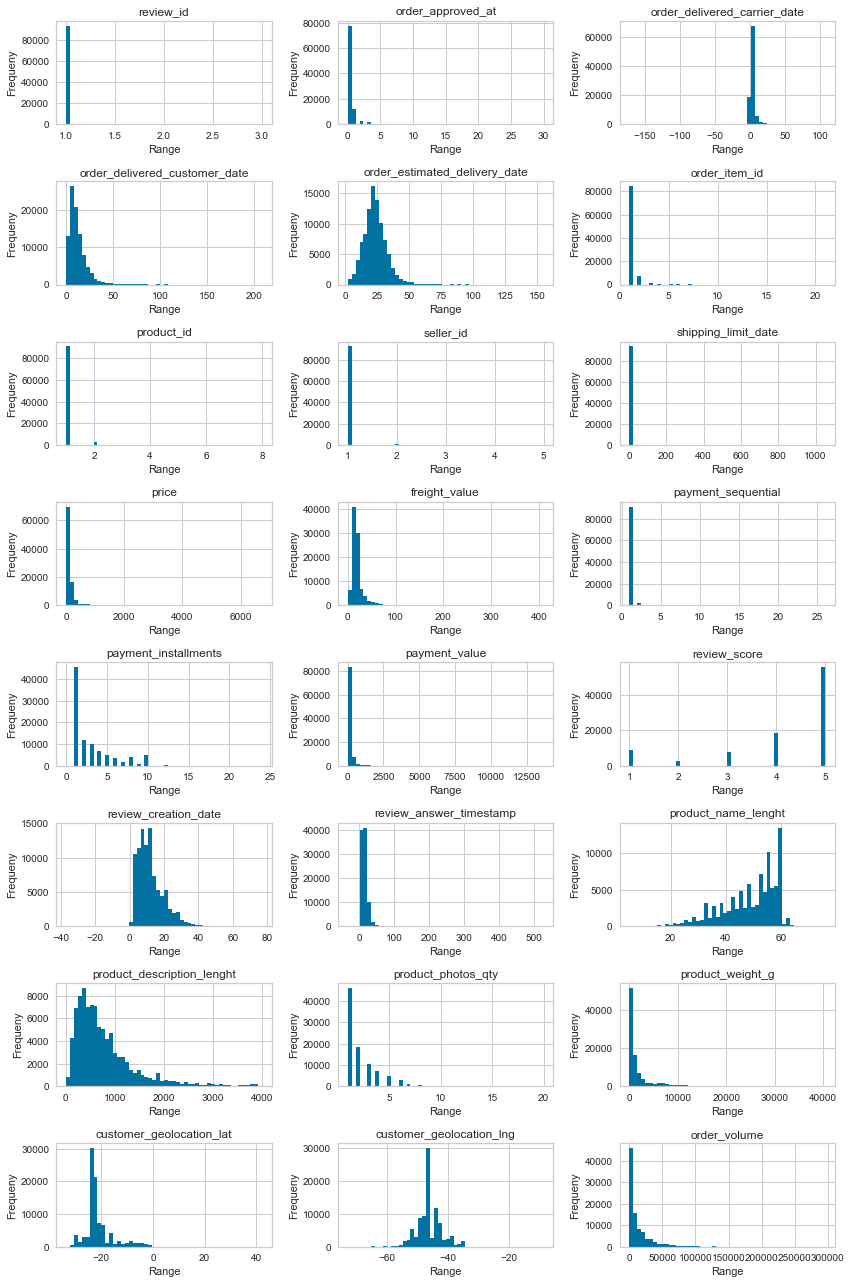

In [1961]:
plt.subplots(nrows=8, ncols=3, figsize=(12, 18))

for i in range(1,25):
    plt.subplot(8, 3, i)
    plt.hist(df_orders_translated.iloc[:,i-1], bins = 50)
    plt.xlabel('Range')
    plt.ylabel('Frequeny')
    plt.title(df_orders_translated.columns[i-1])
    
plt.tight_layout()    
plt.show()

### Modelling & Evaluation

We will start by utilizing K-mean to cluster our data and try to find customer with similarities.

First, since K-means is a distance based model, we have to scale our data before modelling.

In [1860]:
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler()
df_orders_translated_ss = s_scaler.fit_transform(df_orders_translated)

let us look at the data in a dataframe.

In [1861]:
pd.DataFrame(df_orders_translated_ss, columns = df_orders_translated.columns)

,review_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,order_volume,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,product_category_name_english_agro_industry_and_commerce,product_category_name_english_air_conditioning,product_category_name_english_art,product_category_name_english_arts_and_craftmanship,product_category_name_english_audio,product_category_name_english_auto,product_category_name_english_baby,product_category_name_english_bed_bath_table,product_category_name_english_books_general_interest,product_category_name_english_books_imported,product_category_name_english_books_technical,product_category_name_english_cds_dvds_musicals,product_category_name_english_christmas_supplies,product_category_name_english_cine_photo,product_category_name_english_computers,product_category_name_english_computers_accessories,product_category_name_english_consoles_games,product_category_name_english_construction_tools_construction,product_category_name_english_construction_tools_lights,product_category_name_english_construction_tools_safety,product_category_name_english_cool_stuff,product_category_name_english_costruction_tools_garden,product_category_name_english_costruction_tools_tools,product_category_name_english_diapers_and_hygiene,product_category_name_english_drinks,product_category_name_english_dvds_blu_ray,product_category_name_english_electronics,product_category_name_english_fashio_female_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_fashion_childrens_clothes,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_shoes,product_category_name_english_fashion_sport,product_category_name_english_fashion_underwear_beach,product_category_name_english_fixed_telephony,product_category_name_english_flowers,product_category_name_english_food,product_category_name_english_food_drink,product_category_name_english_furniture_bedroom,product_category_name_english_furniture_decor,product_category_name_english_furniture_living_room,product_category_name_english_furniture_mattress_and_upholstery,product_category_name_english_garden_tools,product_category_name_english_health_beauty,product_category_name_english_home_appliances,product_category_name_english_home_appliances_2,product_category_name_english_home_comfort_2,product_category_name_english_home_confort,product_category_name_english_home_construction,product_category_name_english_housewares,product_category_name_english_industry_commerce_and_business,product_category_name_english_kitchen_dining_laundry_garden_furniture,product_category_name_english_la_cuisine,product_category_name_english_luggage_accessories,product_category_name_english_market_place,product_category_name_english_music,product_category_name_english_musical_instruments,product_category_name_english_office_furniture,product_category_name_english_party_supplies,product_category_name_english_perfumery,product_category_name_english_pet_shop,product_category_name_english_security_and_services,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
0,-0.073651,-0.361825,-0.203065,-0.427097,-0.953764,-0.264431,-0.168178,-0.11158,-0.514819,-0.505862,-0.727857,5.2867

In [1862]:
from sklearn.cluster import KMeans

In [2012]:
# Look over a range of K values
k_range = np.arange(1, 20)

# Instantiate an empty list of inertias
inertia_list = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k) # k=1, 2,... 19

    # Fit
    k_means_model.fit(df_orders_translated_ss)
    
    # Get inertia and add to list
    inertia_list.append(k_means_model.inertia_)
    print(f'K-means for k =  {k} finished.', end='\r')

Now let us use the elbow method to use the most appropriate k value.

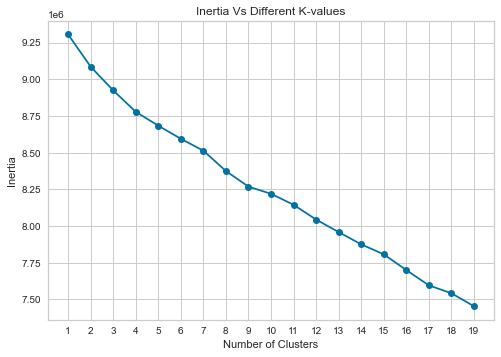

In [2013]:
# Visualize different k values
plt.figure()
plt.plot(k_range, inertia_list, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Vs Different K-values')
plt.xticks(k_range)
plt.show();

The StandardScaler scree plot seems strange. There is no elbow on the plot until 19 clusters to chose as our optimum cluster value, there is no point on going beyond that. Let us use MinMaxscaler as our scaling instead and see if we get different results.

In [2015]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
df_orders_translated_mm = mm_scaler.fit_transform(df_orders_translated)

In [2016]:
# Look over a range of K values
k_range = np.arange(1, 20)

# Instantiate an empty list of inertias
inertia_list = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k) # k=1, 2,... 19

    # Fit
    k_means_model.fit(df_orders_translated_mm)
    
    # Get inertia and add to list
    inertia_list.append(k_means_model.inertia_)
    print(f'K-means for k =  {k} finished.', end='\r')

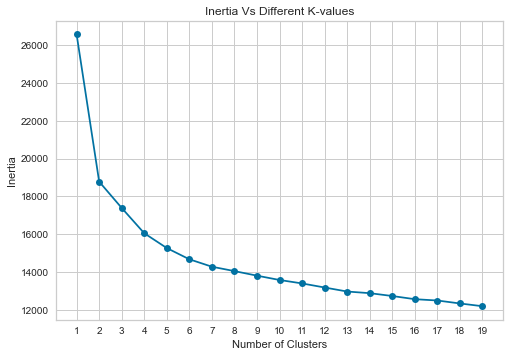

In [2017]:
# Visualize different k values
plt.figure()
plt.plot(k_range, inertia_list, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Vs Different K-values')
plt.xticks(k_range)
plt.show();

Perfect, it is clear here that we can safely say there are **2 clusters, k = 2** on our data. It is clear that the inertia rate of improvement dramatically diminishes after the second cluster. 

We, however to use some other methods to understand and confirm that the our result is optimum. We can use Silhouette score and Davies Bouldin score for this purpose. We will also need to try at least one more non-Euclidean clustering method to get some assurance.

We will come back later and see as to why MinMaxscaler resulted in 6 clusters while StandardScaler did not. For now we will keep moving on out analysis.

Now let us use Silhouette Score to evaluate our clusters. It measures how similar the points in the same clusters which is a composition of the mean distances in the cluster and the mean distances in other clusters.

In [2018]:
from sklearn.metrics import silhouette_score

In [2025]:
# Look over a range of K values
k_range = np.arange(2, 10)

# Instantiate an empty list of silhouette scores
silhouette_scores = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k)

    # Fit
    k_means_model.fit(df_orders_translated_mm)
    
    # Get cluster labels and calculate silhouette score
    cluster_labels = k_means_model.predict(df_orders_translated_mm)
    silhouette = silhouette_score(df_orders_translated_mm, cluster_labels)
    
    # Append to list
    silhouette_scores.append(silhouette)
    print(f'silhouette_scores for k =  {k} finished.', end='\r')

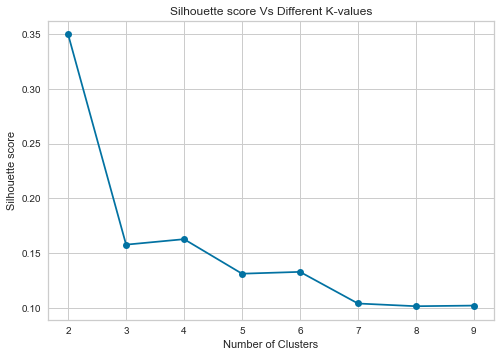

In [2026]:
# plot the Silhouette score 
plt.figure()
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score Vs Different K-values')
plt.xticks(k_range)
plt.show();

The silhouette scores plot confirms our earlier result from the elbow method we used to determine the best value for k. the higher the score the better the Homogeneity of the cluster.

Using the Yellowbrick SilhouetteVisualizer is another way of looking at the clustering results from a different angle.

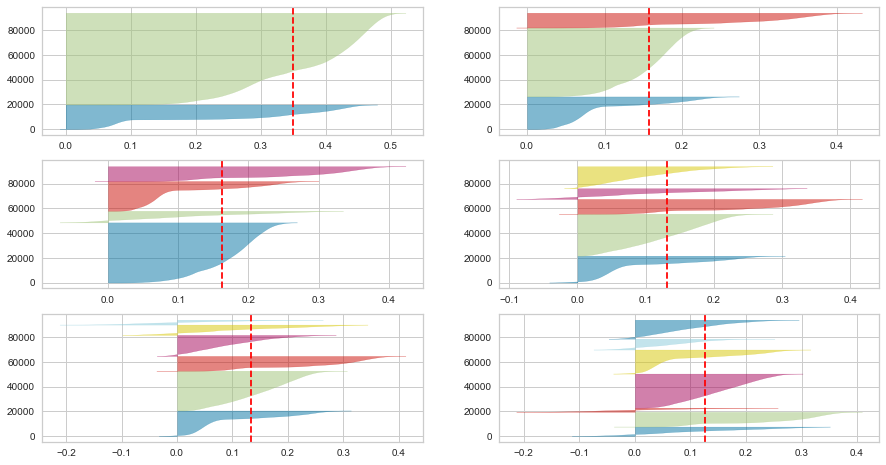

In [1889]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    k_means_model = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(k_means_model, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_orders_translated_mm)

The plot above is a comparison between 6 different scenarios, where each scenario represents a number of clusters, 2 to 7 respectively. As the number of cluster increases we see the following:
- the average Silhouette score of all clusters, represented by the vertical dashed line decreases meaning that we are not optimizing as we increase the number of clusters
- the jump of the average score is clear from 2 clusters to 3 clusters (down to ~0.16 from ~0.35) indicating that 2 is the optimum value
- as we increase clusters, more points tend to have negative Silhouette score confirming that clusters start to become less homogenous 
- it is also noticed that for k = 2, the first cluster is almost three times as much the size of the second cluster

Now we can use even a third way to evaluate our findings, the davies_bouldin_score. This score is a measure of the ratio between the cluster scatter and the cluster separation. Again, it is another way to see how the points falling in the same cluster look like each other and how the cluster looks like having these points.

In [2027]:
from sklearn.metrics import davies_bouldin_score

# Instantiate an empty list of Davies Bouldin Index
DB_scores = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k)

    # Fit
    k_means_model.fit(df_orders_translated_mm)
    
    # Get cluster labels and calculate silhouette score
    cluster_labels = k_means_model.predict(df_orders_translated_mm)
    DB = davies_bouldin_score(df_orders_translated_mm, cluster_labels)
    
    # Append to list
    DB_scores.append(DB)
    print(f'Davies Bouldin Index for k =  {k} finished.', end='\r')

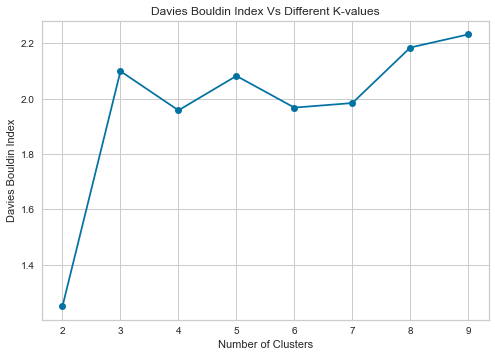

In [2028]:
# plot the Davies Bouldin Index
plt.figure()
plt.plot(k_range, DB_scores, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Index')
plt.title('Davies Bouldin Index Vs Different K-values')
plt.xticks(k_range)
plt.show();

The plot result is agreement with our previous findings, the lowest value is for k = n, not only that but the jump is relatively high from k = 2 to k = 3.

Next, we will try to rerun the above but without:
- geolocation data
- the sparse data; ie the other payment method and the product type data.

The objective of this is to confirm that these features have not heavily impacted and biased the results due to their distribution.

Without the geolocation data.

In [2030]:
df_orders_translated_ng = df_orders_translated.drop(['customer_geolocation_lat', 'customer_geolocation_lng'], axis = 1)

In [2031]:
df_orders_translated.shape, df_orders_translated_ng.shape

((93996, 99), (93996, 97))

In [2034]:
s_scaler = StandardScaler()
df_orders_translated_ng_ss = s_scaler.fit_transform(df_orders_translated_ng)

# Look over a range of K values
k_range = np.arange(1, 10)

# Instantiate an empty list of inertias
inertia_list = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k) # k=1, 2,... 19

    # Fit
    k_means_model.fit(df_orders_translated_ng_ss)
    
    # Get inertia and add to list
    inertia_list.append(k_means_model.inertia_)
    print(f'K-means for k =  {k} finished.', end='\r')

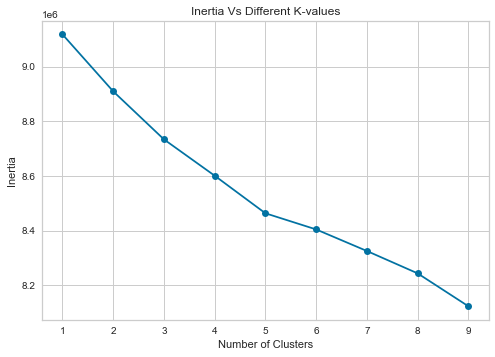

In [2035]:
# Visualize different k values
plt.figure()
plt.plot(k_range, inertia_list, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Vs Different K-values')
plt.xticks(k_range)
plt.show();

Using MinMaxScaler:

In [2037]:
mm_scaler = MinMaxScaler()
df_orders_translated_ng_mm = mm_scaler.fit_transform(df_orders_translated_ng)

# Look over a range of K values
k_range = np.arange(1, 10)

# Instantiate an empty list of inertias
inertia_list = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k) # k=1, 2,... 19

    # Fit
    k_means_model.fit(df_orders_translated_ng_mm)
    
    # Get inertia and add to list
    inertia_list.append(k_means_model.inertia_)
    print(f'K-means for k =  {k} finished.', end='\r')

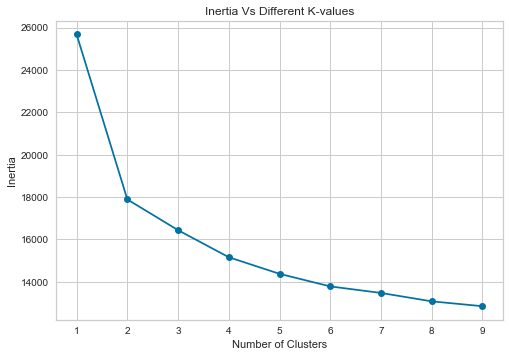

In [2038]:
# Visualize different k values
plt.figure()
plt.plot(k_range, inertia_list, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Vs Different K-values')
plt.xticks(k_range)
plt.show();

Try without the sparse data:

In [2039]:
df_orders_translated.columns[:-75]

Index(['review_id', 'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_installments',
       'payment_value', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'customer_geolocation_lat', 'customer_geolocation_lng', 'order_volume'],
      dtype='object')

In [2040]:
df_orders_translated_ns = df_orders_translated[df_orders_translated.columns[:-75]]

In [2041]:
df_orders_translated.shape, df_orders_translated_ns.shape

((93996, 99), (93996, 24))

In [2042]:
s_scaler = StandardScaler()
df_orders_translated_ns_ss = s_scaler.fit_transform(df_orders_translated_ns)

# Look over a range of K values
k_range = np.arange(1, 10)

# Instantiate an empty list of inertias
inertia_list = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k) # k=1, 2,... 19

    # Fit
    k_means_model.fit(df_orders_translated_ns_ss)
    
    # Get inertia and add to list
    inertia_list.append(k_means_model.inertia_)
    print(f'K-means for k =  {k} finished.', end='\r')

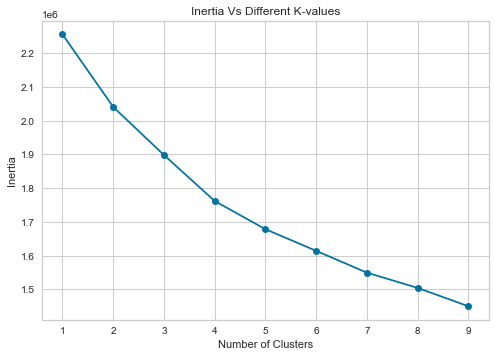

In [2043]:
# Visualize different k values
plt.figure()
plt.plot(k_range, inertia_list, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Vs Different K-values')
plt.xticks(k_range)
plt.show();

Using MinMaxScaler:

In [2044]:
mm_scaler = MinMaxScaler()
df_orders_translated_ns_mm = mm_scaler.fit_transform(df_orders_translated_ns)

# Look over a range of K values
k_range = np.arange(1, 10)

# Instantiate an empty list of inertias
inertia_list = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k) # k=1, 2,... 19

    # Fit
    k_means_model.fit(df_orders_translated_ns_mm)
    
    # Get inertia and add to list
    inertia_list.append(k_means_model.inertia_)
    print(f'K-means for k =  {k} finished.', end='\r')

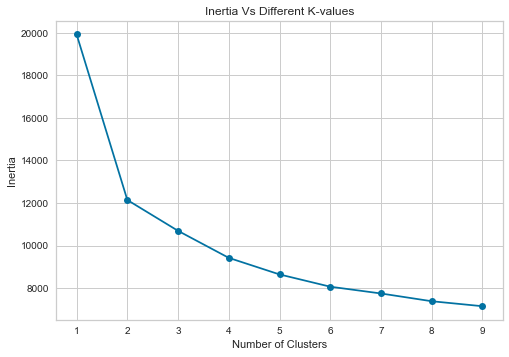

In [2045]:
# Visualize different k values
plt.figure()
plt.plot(k_range, inertia_list, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Vs Different K-values')
plt.xticks(k_range)
plt.show();

It is clear that both the geolocation features and sparse features have low impact of the number of clusters.

The following is the use of GMM to confirm that our data is clustered into two clusters in case the data does not take a uniform sphere-like shape where K-means some times fall short.

GMM

In [2098]:
from sklearn import mixture

In [2198]:
len(df_orders_translated_mm)

93996

In [ ]:
# Look over a range of K values
k_range = np.arange(2, 10)

# Instantiate an empty list of silhouette scores
silhouette_scores = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')

    # Fit
    gmm.fit(df_orders_translated_mm)
    
    # Get cluster labels and calculate silhouette score
    cluster_labels = gmm.predict(df_orders_translated_mm)
    silhouette = silhouette_score(df_orders_translated_mm, cluster_labels)
    
    # Append to list
    silhouette_scores.append(silhouette)
    print(f'silhouette_scores for k =  {k} finished.', end='\r')

In [ ]:
# plot the Silhouette score 
plt.figure()
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score Vs Different GMM Clusters')
plt.xticks(k_range)
plt.show();

Again, Based on the silhouette_scores plot above. two (2) clusters is the optimum value as the score is decreasing.

Now,let us look at our clusters from close and do some analysis to see the similarities among each cluster.

In [2046]:
# Run the model for k = 2
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_orders_translated_mm)
clusters = kmeans.predict(df_orders_translated_mm)

In [2048]:
# assign each instance to its cluster on the dataframe
df_orders_translated["cluster"] = clusters

In [2054]:
df_orders_translated.head()

,review_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,order_volume,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,product_category_name_english_agro_industry_and_commerce,product_category_name_english_air_conditioning,product_category_name_english_art,product_category_name_english_arts_and_craftmanship,product_category_name_english_audio,product_category_name_english_auto,product_category_name_english_baby,product_category_name_english_bed_bath_table,product_category_name_english_books_general_interest,product_category_name_english_books_imported,product_category_name_english_books_technical,product_category_name_english_cds_dvds_musicals,product_category_name_english_christmas_supplies,product_category_name_english_cine_photo,product_category_name_english_computers,product_category_name_english_computers_accessories,product_category_name_english_consoles_games,product_category_name_english_construction_tools_construction,product_category_name_english_construction_tools_lights,product_category_name_english_construction_tools_safety,product_category_name_english_cool_stuff,product_category_name_english_costruction_tools_garden,product_category_name_english_costruction_tools_tools,product_category_name_english_diapers_and_hygiene,product_category_name_english_drinks,product_category_name_english_dvds_blu_ray,product_category_name_english_electronics,product_category_name_english_fashio_female_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_fashion_childrens_clothes,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_shoes,product_category_name_english_fashion_sport,product_category_name_english_fashion_underwear_beach,product_category_name_english_fixed_telephony,product_category_name_english_flowers,product_category_name_english_food,product_category_name_english_food_drink,product_category_name_english_furniture_bedroom,product_category_name_english_furniture_decor,product_category_name_english_furniture_living_room,product_category_name_english_furniture_mattress_and_upholstery,product_category_name_english_garden_tools,product_category_name_english_health_beauty,product_category_name_english_home_appliances,product_category_name_english_home_appliances_2,product_category_name_english_home_comfort_2,product_category_name_english_home_confort,product_category_name_english_home_construction,product_category_name_english_housewares,product_category_name_english_industry_commerce_and_business,product_category_name_english_kitchen_dining_laundry_garden_furniture,product_category_name_english_la_cuisine,product_category_name_english_luggage_accessories,product_category_name_english_market_place,product_category_name_english_music,product_category_name_english_musical_instruments,product_category_name_english_office_furniture,product_category_name_english_party_supplies,product_category_name_english_perfumery,product_category_name_english_pet_shop,product_category_name_english_security_and_services,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts,cluster
0,1,0.0,2.0,8.0,15.0,1,1,1,4.0,29.990000,8.720000,3,1,38.709999,4.0,8.0,9.0,40.0,268.0,4.0,500.0,-23.576982,-

In [2056]:
df_orders_translated["cluster"].value_counts()

0    74218
1    19778
Name: cluster, dtype: int64

It seems most of our customers (around 70%) fall in the first cluster while the rest fall in the second cluster. But what makes them different. let us look at the differences between them.

In [2063]:
df_orders_translated.iloc[:,i-1].name

'order_volume'

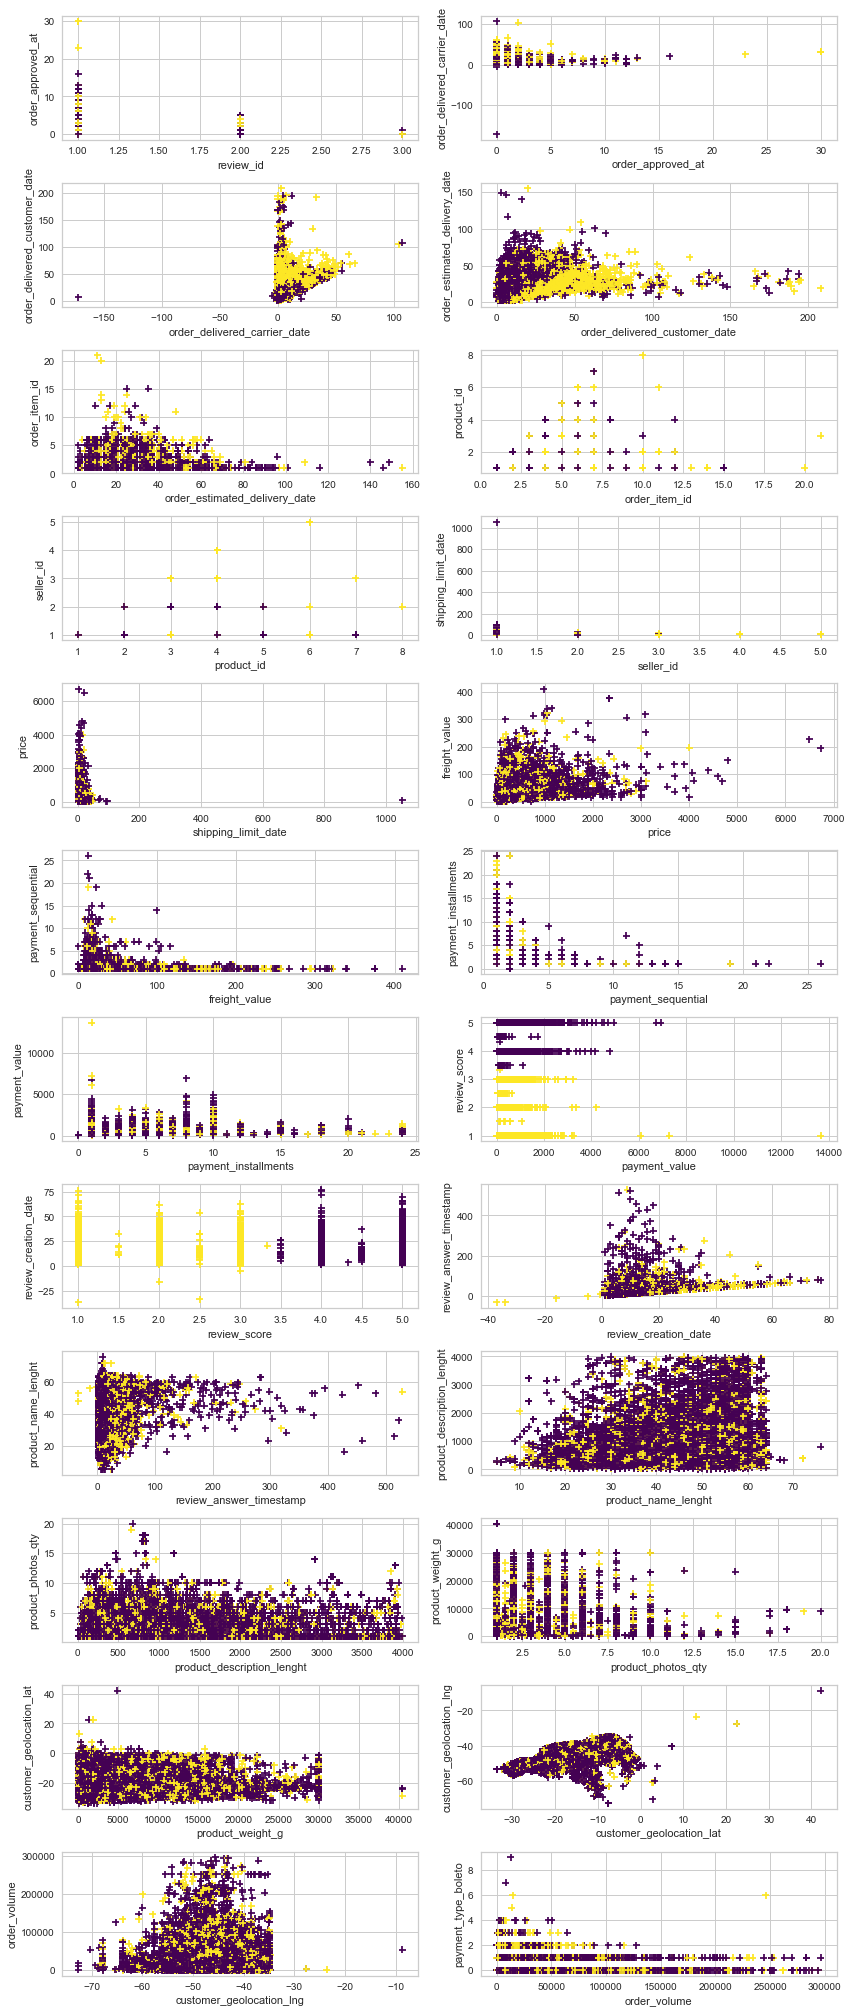

In [2086]:
plt.subplots(nrows=12, ncols=2, figsize=(12, 28))

for i in range(1,25):
    plt.subplot(12, 2, i)
    plt.scatter(df_orders_translated.iloc[:,i-1], df_orders_translated.iloc[:,i], c = clusters, cmap = 'viridis', marker ="+")
    plt.xlabel(df_orders_translated.iloc[:,i-1].name)
    plt.ylabel(df_orders_translated.iloc[:,i].name)
#     plt.title(df_orders_translated.columns[i-1])
    
plt.tight_layout()    
plt.show()

In [2084]:
df_orders_translated_cluster_means = df_orders_translated.groupby('cluster').mean()

In [2161]:
df_orders_translated_cluster_means = df_orders_translated_cluster_means.reset_index()

In [2165]:
df_orders_translated_cluster_means

,cluster,review_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,customer_geolocation_lat,customer_geolocation_lng,order_volume,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,product_category_name_english_agro_industry_and_commerce,product_category_name_english_air_conditioning,product_category_name_english_art,product_category_name_english_arts_and_craftmanship,product_category_name_english_audio,product_category_name_english_auto,product_category_name_english_baby,product_category_name_english_bed_bath_table,product_category_name_english_books_general_interest,product_category_name_english_books_imported,product_category_name_english_books_technical,product_category_name_english_cds_dvds_musicals,product_category_name_english_christmas_supplies,product_category_name_english_cine_photo,product_category_name_english_computers,product_category_name_english_computers_accessories,product_category_name_english_consoles_games,product_category_name_english_construction_tools_construction,product_category_name_english_construction_tools_lights,product_category_name_english_construction_tools_safety,product_category_name_english_cool_stuff,product_category_name_english_costruction_tools_garden,product_category_name_english_costruction_tools_tools,product_category_name_english_diapers_and_hygiene,product_category_name_english_drinks,product_category_name_english_dvds_blu_ray,product_category_name_english_electronics,product_category_name_english_fashio_female_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_fashion_childrens_clothes,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_shoes,product_category_name_english_fashion_sport,product_category_name_english_fashion_underwear_beach,product_category_name_english_fixed_telephony,product_category_name_english_flowers,product_category_name_english_food,product_category_name_english_food_drink,product_category_name_english_furniture_bedroom,product_category_name_english_furniture_decor,product_category_name_english_furniture_living_room,product_category_name_english_furniture_mattress_and_upholstery,product_category_name_english_garden_tools,product_category_name_english_health_beauty,product_category_name_english_home_appliances,product_category_name_english_home_appliances_2,product_category_name_english_home_comfort_2,product_category_name_english_home_confort,product_category_name_english_home_construction,product_category_name_english_housewares,product_category_name_english_industry_commerce_and_business,product_category_name_english_kitchen_dining_laundry_garden_furniture,product_category_name_english_la_cuisine,product_category_name_english_luggage_accessories,product_category_name_english_market_place,product_category_name_english_music,product_category_name_english_musical_instruments,product_category_name_english_office_furniture,product_category_name_english_party_supplies,product_category_name_english_perfumery,product_category_name_english_pet_shop,product_category_name_english_security_and_services,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
0,0,1.005187,0.258455,2.469024,10.608653,23.152645,1.111065,1.026516,1.006683,6.334309,125.191879,19.920090,1

In [2157]:
df_orders_translated_cluster_means.index.name

'cluster'

In [2169]:
df_orders_translated_cluster_means.iloc[:,1]

0    1.005187
1    1.006573
Name: review_id, dtype: float64

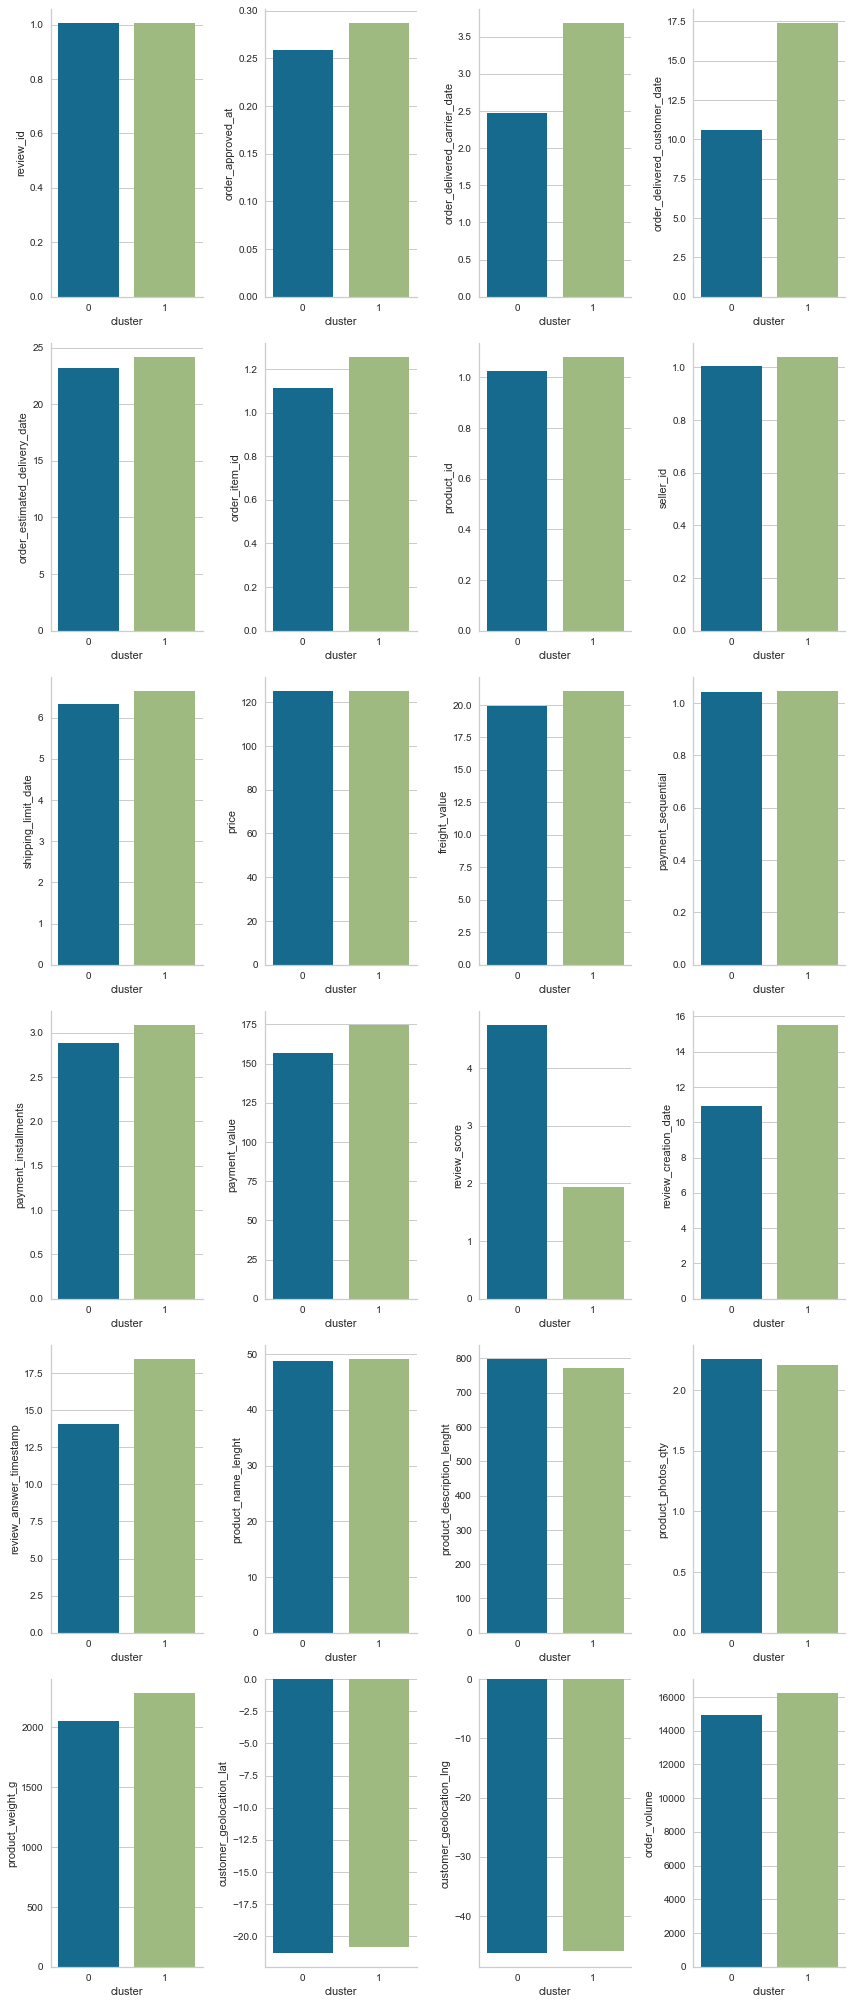

In [2185]:
plt.subplots(nrows=6, ncols=4, figsize=(12, 28))

for i in range(1,25):
    plt.subplot(6, 4, i)
    sns.barplot(x = 'cluster', y = df_orders_translated_cluster_means.iloc[:,i], data = df_orders_translated_cluster_means)
    sns.despine()
plt.tight_layout()    
plt.show()